In [2]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
 
import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score
 
import scipy

import statsmodels.api
import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os
import lightgbm as lgb

Using TensorFlow backend.


# 1. Data Load

## 1) 데이터 불러오기

### (1) 기본 데이터

In [3]:
dangjin_fcst = pd.read_csv("data/dangjin_fcst_data.csv")
dangjin_obs = pd.read_csv("data/dangjin_obs_data.csv")
energy = pd.read_csv("data/energy.csv")
site_info = pd.read_csv("data/site_info.csv")
ulsan_fcst = pd.read_csv("data/ulsan_fcst_data.csv")
ulsan_obs = pd.read_csv("data/ulsan_obs_data.csv")

### (2) 추가 데이터

#### - 강수확률(당진)

In [4]:
dirlist = os.listdir("data")

searcher = re.compile("석문면_강수확률")

searcher_2 = re.compile("[0-9]{8,9}")

In [5]:
index = pd.Series(dirlist).apply(lambda x : len(searcher.findall(x)) != 0)

In [6]:

fall_prob = DataFrame()

for i in Series(dirlist)[index].reset_index(drop = True):

    csv_file = pd.read_csv('data/' + i)

    index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

    index_list.append(len(csv_file))

    csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

    for j in range(0, len(index_list) - 1):
        
        csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

    csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)

    csv_file.columns = ["day","hour","forecast_time","value","date"]

    csv_file["day"] = csv_file["day"].astype("int") - 1

    csv_file["date"] = pd.to_datetime(csv_file["date"])

    csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

    csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

    csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)

    csv_file = csv_file.drop(["date","day","hour"], axis = 1)[["time","forecast_time","value"]]
    
    fall_prob = pd.concat([fall_prob,csv_file])

#### - 강수 형태(당진)

In [7]:
dirlist = os.listdir("data")

searcher = re.compile("석문면_강수형태")

searcher_2 = re.compile(" [0-9]{8,9}")

In [8]:
index = pd.Series(dirlist).apply(lambda x : len(searcher.findall(x)) != 0)

In [9]:

fall_type = DataFrame()

for i in Series(dirlist)[index].reset_index(drop = True):

    csv_file = pd.read_csv('data/' + i)

    index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

    index_list.append(len(csv_file))

    csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

    for j in range(0, len(index_list) - 1):
        
        csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

    csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)

    csv_file.columns = ["day","hour","forecast_time","value","date"]

    csv_file["day"] = csv_file["day"].astype("int") - 1

    csv_file["date"] = pd.to_datetime(csv_file["date"])

    csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

    csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

    csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)

    csv_file = csv_file.drop(["date","day","hour"], axis = 1)[["time","forecast_time","value"]]
    
    fall_type = pd.concat([fall_type,csv_file])

In [10]:
rain = pd.merge(fall_type, fall_prob, on = ["time","forecast_time"])

In [11]:
rain.columns = ["Forecast time","forecast","fall_type_dangjin","fall_prob_dangjin"]

#### - 강수확률(울산)

In [12]:
dirlist = os.listdir("data")

searcher = re.compile("선암동_강수확률")

searcher_2 = re.compile("[0-9]{8,9}")

In [13]:
index = pd.Series(dirlist).apply(lambda x : len(searcher.findall(x)) != 0)

In [14]:

fall_prob = DataFrame()

for i in Series(dirlist)[index].reset_index(drop = True):

    csv_file = pd.read_csv('data/' + i)

    index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

    index_list.append(len(csv_file))

    csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

    for j in range(0, len(index_list) - 1):
        
        csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

    csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)

    csv_file.columns = ["day","hour","forecast_time","value","date"]

    csv_file["day"] = csv_file["day"].astype("int") - 1

    csv_file["date"] = pd.to_datetime(csv_file["date"])

    csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

    csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

    csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)

    csv_file = csv_file.drop(["date","day","hour"], axis = 1)[["time","forecast_time","value"]]
    
    fall_prob = pd.concat([fall_prob,csv_file])

#### - 강수 형태(울산)

In [15]:
dirlist = os.listdir("data")

searcher = re.compile("선암동_강수형태")

searcher_2 = re.compile(" [0-9]{8,9}")

In [16]:
index = pd.Series(dirlist).apply(lambda x : len(searcher.findall(x)) != 0)

In [17]:

fall_type = DataFrame()

for i in Series(dirlist)[index].reset_index(drop = True):

    csv_file = pd.read_csv('data/' + i)

    index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

    index_list.append(len(csv_file))

    csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

    for j in range(0, len(index_list) - 1):
        
        csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

    csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)

    csv_file.columns = ["day","hour","forecast_time","value","date"]

    csv_file["day"] = csv_file["day"].astype("int") - 1

    csv_file["date"] = pd.to_datetime(csv_file["date"])

    csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

    csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

    csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)

    csv_file = csv_file.drop(["date","day","hour"], axis = 1)[["time","forecast_time","value"]]
    
    fall_type = pd.concat([fall_type,csv_file])

In [18]:
rain_ulsan = pd.merge(fall_type, fall_prob, on = ["time","forecast_time"])

In [19]:
rain_ulsan.columns = ["Forecast time","forecast","fall_type_ulsan","fall_prob_ulsan"]

In [20]:
rain = pd.merge(rain,rain_ulsan, on = ["Forecast time","forecast"])

#### - 과거 발전량

In [21]:
energy_past = pd.read_csv('data/한국동서발전 시간대별 태양광 발전량 현황(2015_2017).csv',encoding = "CP949")

energy_past = energy_past.reset_index()

energy_stack = energy_past[[str(i) for i in range(1, 25)]].unstack().reset_index()

energy_stack.columns = ["hour","index","value"]

energy_past = pd.merge(energy_stack,energy_past.iloc[:,0:4])

energy_past["시간"] = energy_past["시간"] + ' ' + energy_past["hour"] + ":00:00"

energy_past = energy_past.drop(["hour","index","용량(MW)"], axis = 1)

energy_past = energy_past.pivot(index = ["시간"], columns = ["태양광명"], values = ["value"])

energy_past.columns = DataFrame(list(energy_past.columns))[1]

energy_past = energy_past.reset_index()

energy_past = energy_past[["시간", "당진자재창고태양광","당진태양광","울산태양광","당진취수로태양광"]]

energy_past.columns = ["time","dangjin_warehouse","dangjin","ulsan","dangjin_floating"]

In [22]:
energy = pd.concat([energy_past, energy]).reset_index(drop = True)

#### - 과거 예측(당진)

In [23]:
searcher_2 = re.compile("[0-9]{8,9}")
searcher_3 = re.compile("[a-zA-Z]+")

In [24]:
fall_type = DataFrame()

for i in range(0, len(os.listdir("data/weather/dangjin"))):
    file_list = os.listdir("data/weather/dangjin/" + os.listdir("data/weather/dangjin/")[i])
    
    for n,k in enumerate(file_list):
        
        csv_file = pd.read_csv("data/weather/dangjin/" + os.listdir("data/weather/dangjin")[i] + "/" + k)

        index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

        index_list.append(len(csv_file))

        csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

        for j in range(0, len(index_list) - 1):

            csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

        index_list = list(set(index_list).union(
                set(list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_3.findall(x)) != 0)].index))))

        index_list.sort()

        csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)
        
        csv_file = csv_file.drop_duplicates().reset_index(drop = True)

        csv_file.columns = ["day","hour","forecast_time",k.split("_")[1] ,"date"]

        csv_file["day"] = csv_file["day"].astype("int") - 1

        csv_file["date"] = pd.to_datetime(csv_file["date"])

        csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

        csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

        csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)
        
        if n == 0:
        
            temp_result = csv_file.copy()
        
        else : 
            temp_result = pd.merge(temp_result, csv_file, on = ["day","hour", "time", "forecast_time", "date"]).drop_duplicates()
        
    fall_type = pd.concat([fall_type, temp_result])

In [25]:
fall_type = fall_type.reset_index(drop = True)

dangjin_fcst_past = fall_type.drop(["date","day","hour"], axis = 1)[["time","forecast_time","3시간기온","강수형태","강수확률","습도","풍속","풍향","하늘상태"]]

dangjin_fcst_past.columns = ["Forecast time","forecast","Temperature","fall_type_dangjin","fall_prob_dangjin","Humidity","WindSpeed","WindDirection","Cloud"]

rain_dangjin = dangjin_fcst_past[["Forecast time","forecast","fall_type_dangjin","fall_prob_dangjin"]]

dangjin_fcst_past = dangjin_fcst_past.drop(["fall_type_dangjin","fall_prob_dangjin"], axis = 1)

In [26]:
dangjin_fcst = pd.concat([dangjin_fcst_past,dangjin_fcst]).reset_index(drop = True)

In [27]:
dangjin_fcst["forecast"] = dangjin_fcst["forecast"].astype(int)

dangjin_fcst["Forecast time"] = dangjin_fcst["Forecast time"].astype(str)

In [28]:
fall_type = fall_type.reset_index(drop = True)

dangjin_fcst_past = fall_type.drop(["date","day","hour"], axis = 1)[["time","forecast_time","3시간기온","강수형태","강수확률","습도","풍속","풍향","하늘상태"]]

dangjin_fcst_past.columns = ["Forecast time","forecast","Temperature","fall_type_dangjin","fall_prob_dangjin","Humidity","WindSpeed","WindDirection","Cloud"]

rain_dangjin = dangjin_fcst_past[["Forecast time","forecast","fall_type_dangjin","fall_prob_dangjin"]]

dangjin_fcst_past = dangjin_fcst_past.drop(["fall_type_dangjin","fall_prob_dangjin"], axis = 1)

In [29]:
dangjin_fcst = pd.concat([dangjin_fcst_past,dangjin_fcst]).reset_index(drop = True)

In [30]:
dangjin_fcst["forecast"] = dangjin_fcst["forecast"].astype(int)

dangjin_fcst["Forecast time"] = dangjin_fcst["Forecast time"].astype(str)

#### - 과거 예측(울산)

In [31]:
searcher_2 = re.compile("[0-9]{8,9}")
searcher_3 = re.compile("[a-zA-Z]+")

In [32]:
fall_type = DataFrame()

for i in range(0, len(os.listdir("data/weather/ulsan"))):
    file_list = os.listdir("data/weather/ulsan/" + os.listdir("data/weather/ulsan/")[i])
    
    for n,k in enumerate(file_list):
        
        csv_file = pd.read_csv("data/weather/ulsan/" + os.listdir("data/weather/ulsan")[i] + "/" + k)

        index_list = list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_2.findall(x)) != 0)].index)

        index_list.append(len(csv_file))

        csv_file.loc[0 : index_list[1],"date"] = searcher_2.findall(csv_file.columns[3])[0]

        for j in range(0, len(index_list) - 1):

            csv_file.loc[index_list[j] : index_list[j + 1],"date"] = searcher_2.findall(csv_file.iloc[index_list[j],0])[0]

        index_list = list(set(index_list).union(
                set(list(csv_file[csv_file.iloc[:,0].apply(lambda x : len(searcher_3.findall(x)) != 0)].index))))

        index_list.sort()

        csv_file = csv_file.drop(index_list[:-1], axis = 0).reset_index(drop = True)
        
        csv_file = csv_file.drop_duplicates().reset_index(drop = True)

        csv_file.columns = ["day","hour","forecast_time",k.split("_")[1] ,"date"]

        csv_file["day"] = csv_file["day"].astype("int") - 1

        csv_file["date"] = pd.to_datetime(csv_file["date"])

        csv_file["hour"] = csv_file["hour"].astype("str").str.split(".").apply(lambda x : x[0][:-2])

        csv_file["time"] = csv_file.apply(lambda x : x["date"] + pd.Timedelta(x["day"], unit = "d"), axis = 1)

        csv_file["time"] = csv_file.apply(lambda x : x["time"] + pd.Timedelta(x["hour"] + ":00:00"), axis = 1)
        
        if n == 0:
        
            temp_result = csv_file.copy()
        
        else : 
            temp_result = pd.merge(temp_result, csv_file, on = ["day","hour", "time", "forecast_time", "date"]).drop_duplicates()
        
    fall_type = pd.concat([fall_type, temp_result])

In [33]:
fall_type = fall_type.reset_index(drop = True)

ulsan_fcst_past = fall_type.drop(["date","day","hour"], axis = 1)[["time","forecast_time","3시간기온","강수형태","강수확률","습도","풍속","풍향","하늘상태"]]

ulsan_fcst_past.columns = ["Forecast time","forecast","Temperature","fall_type_ulsan","fall_prob_ulsan","Humidity","WindSpeed","WindDirection","Cloud"]

rain_ulsan = ulsan_fcst_past[["Forecast time","forecast","fall_type_ulsan","fall_prob_ulsan"]]

ulsan_fcst_past = ulsan_fcst_past.drop(["fall_type_ulsan","fall_prob_ulsan"], axis = 1)

In [34]:
ulsan_fcst = pd.concat([ulsan_fcst_past,ulsan_fcst]).reset_index(drop = True)

In [35]:
ulsan_fcst["forecast"] = ulsan_fcst["forecast"].astype(int)

ulsan_fcst["Forecast time"] = ulsan_fcst["Forecast time"].astype(str)

In [36]:
rain = pd.concat([pd.merge(rain_dangjin,rain_ulsan, on = ["Forecast time","forecast"]), rain], axis = 0).reset_index(drop = True)

In [37]:
rain["forecast"] = rain["forecast"].astype(int)

rain["Forecast time"] = rain["Forecast time"].astype(str)

rain["fall_type_dangjin"] = rain["fall_type_dangjin"].astype(float).astype(int)

rain["fall_prob_dangjin"] = rain["fall_prob_dangjin"].astype("float")

rain["fall_type_ulsan"] = rain["fall_type_ulsan"].astype(float).astype(int)

rain["fall_prob_ulsan"] = rain["fall_prob_ulsan"].astype("float")

#### -과거 관측

In [38]:
fall_type = DataFrame()

file_list = os.listdir("data/obs/dangjin/")

for n,k in enumerate(file_list):

    csv_file = pd.read_csv("data/obs/dangjin/" + k, encoding = "CP949")
    
    csv_file = csv_file[["일시","기온(°C)","풍속(m/s)","풍향(16방위)","습도(%)","전운량(10분위)"]]

    if n == 0:

        temp_result = csv_file.copy()

    else : 
        temp_result = pd.concat([temp_result, csv_file],axis = 0).drop_duplicates()

dangjin_obs = pd.concat([temp_result,dangjin_obs], axis = 0).drop_duplicates(subset = ["일시"]).reset_index(drop = True)

In [39]:
fall_type = DataFrame()

file_list = os.listdir("data/obs/ulsan/")

for n,k in enumerate(file_list):

    csv_file = pd.read_csv("data/obs/ulsan/" + k, encoding = "CP949")
    
    csv_file = csv_file[["일시","기온(°C)","풍속(m/s)","풍향(16방위)","습도(%)","전운량(10분위)"]]

    if n == 0:

        temp_result = csv_file.copy()

    else : 
        temp_result = pd.concat([temp_result, csv_file],axis = 0).drop_duplicates()

ulsan_obs = pd.concat([temp_result,ulsan_obs], axis = 0).drop_duplicates(subset = ["일시"]).reset_index(drop = True)

In [39]:
dangjin_obs

,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위),지점,지점명
0,2015-01-01 00:00,-4.2,5.3,340.0,48.0,7.0,NaN,NaN
1,2015-01-01 01:00,-4.4,5.4,340.0,47.0,6.0,NaN,NaN
2,2015-01-01 02:00,-4.6,4.9,340.0,50.0,NaN,NaN,NaN
3,2015-01-01 03:00,-4.7,6.2,320.0,50.0,6.0,NaN,NaN
4,2015-01-01 04:00,-5.0,5.0,320.0,56.0,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...
53233,2021-01-31 19:00,6.7,1.5,200.0,75.0,8.0,129.0,서산
53234,2021-01-31 20:00,6.2,0.8,200.0,77.0,8.0,129.0,서산
53235,2021-01-31 21:00,5.3,0.7,230.0,82.0,8.0,129.0,서산
53236,2021-01-31 22:00,5.8,1.0,200.0,77.0,8.0,129.0,서산


#### - 일사량

In [40]:
sun_radio = pd.concat([pd.read_csv("data/OBS_ASOS_TIM_20210509142735.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210509143013.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210509143059.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210525163946.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210525164100.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210525164127.csv",encoding = "CP949"),
                      ]).reset_index(drop = True)

In [41]:
sun_radio["일시"] = sun_radio["일시"] + ":00"

In [42]:
sun_radio_ulsan = pd.concat([pd.read_csv("data/OBS_ASOS_TIM_20210526161235.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210526161318.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210526161340.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210526161401.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210526161419.csv",encoding = "CP949"),
                       pd.read_csv("data/OBS_ASOS_TIM_20210526161438.csv",encoding = "CP949"),
                      ]).reset_index(drop = True)

In [43]:
sun_radio_ulsan["일시"] = sun_radio_ulsan["일시"] + ":00"

In [47]:
file_list = os.listdir("data/fine_dust/")

In [48]:
file_list = Series(file_list).str.split(".")

for n,k in enumerate(file_list):

    if k[1] == "csv":
        try :
            csv_file = pd.read_csv("data/fine_dust/" + k[0] + ".csv")
        except UnicodeDecodeError as e:           
            print(e)
            csv_file = pd.read_csv("data/fine_dust/" + k[0] + ".csv", encoding = "CP949")
        csv_file = csv_file[["측정소명","측정일시","PM10","PM25"]]
        
    if k[1] == "xlsx":
        
        csv_file = pd.read_excel("data/fine_dust/" + k[0] + ".xlsx")
    
        csv_file = csv_file[["측정소명","측정일시","PM10","PM25"]]

    if n == 0:

        temp_result = csv_file.copy()

    else : 
        temp_result = pd.concat([temp_result, csv_file],axis = 0).drop_duplicates()


'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte
'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte
'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte
'utf-8' codec can't decode byte 0xc1 in position 0: invalid start byte


In [200]:
temp_result["측정일시"] = temp_result["측정일시"].astype('str')

temp_result["Forecast time"] = temp_result["측정일시"].str.slice(0,4) + "-" + temp_result["측정일시"].str.slice(4,6) + "-" + temp_result["측정일시"].str.slice(6,8) + " " + temp_result["측정일시"].str.slice(8,10) + ":00:00"

temp_result = temp_result.reset_index(drop = True)

In [201]:
temp = DataFrame(list(DataFrame(list(temp_result["Forecast time"].str.split(" ")))[1].str.split(":")))

temp[0] = temp[0].astype(int)

temp_result.loc[temp[0] == 24, "Forecast time"] = pd.to_datetime(temp_result.loc[temp[0] == 24, "Forecast time"].str.slice(0,10)).apply(lambda x : x + pd.Timedelta(1,unit = 'd')).astype("str")

temp_result.to_csv("data/fine_dust.csv")

In [202]:
fine_dust = temp_result.copy()
del temp_result

In [900]:
fine_dust_dangjin = fine_dust[fine_dust["측정소명"] == "독곶리"]

fine_dust_ulsan = fine_dust[fine_dust["측정소명"] == "부곡동(울산)"]

# 2. EDA

## 1) 결측값 확인

### (1) 미세먼지

#### - 당진

In [204]:
fine_dust_dangjin.apply(lambda x : x.isna().value_counts())

,측정소명,측정일시,PM10,PM25,Forecast time
False,52608.0,52608.0,49364,30853,52608.0
True,NaN,NaN,3244,21755,NaN


In [205]:
fine_dust_dangjin["group"] = fine_dust_dangjin["Forecast time"].str.slice(0,10)

<ipython-input-205-6e4c5335506b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fine_dust_dangjin["group"] = fine_dust_dangjin["Forecast time"].str.slice(0,10)


In [206]:
result = fine_dust_dangjin.groupby("group")["PM10"].apply(lambda x : len(x[x.isna()]))

<AxesSubplot:>

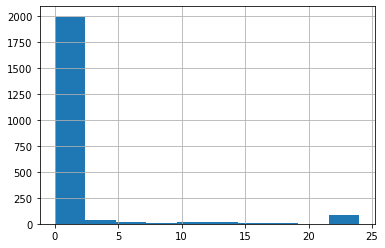

In [207]:
result.hist()

In [208]:
result[result == 0].count()

1794

In [209]:
result[result != 0].count()

399

In [210]:
str(round(399 / (1799 + 393) * 100, 3)) + "%"

'18.203%'

<AxesSubplot:>

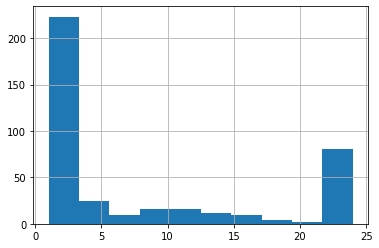

In [211]:
result[result != 0].hist()

In [212]:
result.value_counts()

0     1794
1      101
2      100
24      75
3       22
4       13
5       12
11       9
10       8
6        7
12       7
15       6
14       6
13       6
8        5
23       4
17       3
7        3
9        3
19       3
22       2
21       2
16       1
18       1
Name: PM10, dtype: int64

In [213]:
result[result > 0].value_counts() / len(result[result > 0]) * 100

1     25.313283
2     25.062657
24    18.796992
3      5.513784
4      3.258145
5      3.007519
11     2.255639
10     2.005013
6      1.754386
12     1.754386
13     1.503759
14     1.503759
15     1.503759
8      1.253133
23     1.002506
19     0.751880
9      0.751880
7      0.751880
17     0.751880
22     0.501253
21     0.501253
16     0.250627
18     0.250627
Name: PM10, dtype: float64

미세먼지 결측값을 각 일자별로 묶어서 확인해본 결과, 대부분의 일자에서 NAN이 전혀 없는 경우가 많았지만

약 18%의 일자에서 적어도 하나의 결측값이 존재하고

결측값이 존재하는 경우 한개 ~ 두개인 경우가 약 54%, 20개 이상인 경우가 21% 존재했다.

대략 5개 미만인 경우는 살리고, 그 외의 경우는 버리는 것이 현명해보인다.

#### - 울산

In [909]:
fine_dust_ulsan.apply(lambda x : x.isna().value_counts())

,측정소명,측정일시,PM10,PM25,Forecast time,group
False,52608.0,52608.0,48932,24599,52608.0,52608.0
True,NaN,NaN,3676,28009,NaN,NaN


In [906]:
fine_dust_ulsan["group"] = fine_dust_ulsan["Forecast time"].str.slice(0,10)

<ipython-input-906-ef6938e7cbb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fine_dust_ulsan["group"] = fine_dust_ulsan["Forecast time"].str.slice(0,10)


In [911]:
result = fine_dust_ulsan.groupby("group")["PM10"].apply(lambda x : len(x[x.isna()]))

<AxesSubplot:>

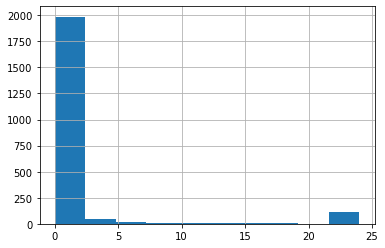

In [912]:
result.hist()

In [913]:
result[result == 0].count()

1761

In [914]:
result[result != 0].count()

432

In [916]:
str(round(432 / (1761 + 432) * 100, 3)) + "%"

'19.699%'

<AxesSubplot:>

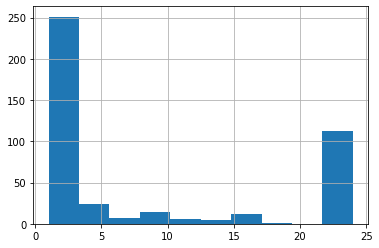

In [917]:
result[result != 0].hist()

In [918]:
result.value_counts()

0     1761
1      153
24     109
2       72
3       26
4       18
9       10
5        6
16       5
15       5
6        5
14       3
12       3
23       3
11       3
10       2
8        2
17       2
7        2
13       2
18       1
Name: PM10, dtype: int64

In [919]:
result[result > 0].value_counts() / len(result[result > 0]) * 100

1     35.416667
24    25.231481
2     16.666667
3      6.018519
4      4.166667
9      2.314815
5      1.388889
6      1.157407
16     1.157407
15     1.157407
14     0.694444
12     0.694444
11     0.694444
23     0.694444
10     0.462963
7      0.462963
8      0.462963
17     0.462963
13     0.462963
18     0.231481
Name: PM10, dtype: float64

In [920]:
35.4+16.6+6+4+1.3

63.3

미세먼지 결측값을 각 일자별로 묶어서 확인해본 결과, 대부분의 일자에서 NAN이 전혀 없는 경우가 많았지만

약 19%의 일자에서 적어도 하나의 결측값이 존재하고

결측값이 존재하는 경우 한개 ~ 두개인 경우가 약 51%, 20개 이상인 경우가 25% 존재했다.

대략 5개 미만인 경우는 살리고, 그 외의 경우는 버리는 것이 현명해보인다.(전체의 63%)

# 3. 데이터 전처리

## 1) 결측값 대체

### (1) 데이터 시간형 처리

In [ ]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])
rain["Forecast_time"] = pd.to_datetime(rain['Forecast time'])

### (2)데이터 보간

#### - 20시 예보 데이터 선별

In [289]:
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==20]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==20]

In [290]:
rain_14 = rain.loc[rain["Forecast_time"].dt.hour == 20]

#### - 24시(자정) 부터 23시까지 데이터 선별

In [291]:
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=(24 - 20))&(dangjin_fcst_14['forecast']<=(48 - 1 - 20))]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=(24 - 20))&(ulsan_fcst_14['forecast']<=(48 - 1 - 20))]

In [292]:
rain_14 = rain_14[(rain_14['forecast']>=(24 - 20))&(rain_14['forecast']<=(48 - 1 - 20))]

In [293]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)
rain_14["Forecast_time"] = rain_14['Forecast_time'] + rain_14['forecast'].map(to_date)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [294]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [295]:
rain_14 = rain_14[["Forecast_time","fall_type_dangjin","fall_prob_dangjin","fall_type_ulsan","fall_prob_ulsan"]].reset_index(drop = True)

In [296]:
rain_14_temp_dangjin = pd.get_dummies(rain_14["fall_type_dangjin"], prefix = "dangjin_type")

else_col = list(set(['dangjin_type_{}'.format(i) for i in range(0, 5)]).difference(set(rain_14_temp_dangjin.columns)))

rain_14_temp_dangjin[else_col] = 0

In [297]:
rain_14_temp_ulsan = pd.get_dummies(rain_14["fall_type_ulsan"], prefix = "ulsan_type")

else_col = list(set(['ulsan_type_{}'.format(i) for i in range(0, 5)]).difference(set(rain_14_temp_ulsan.columns)))

rain_14_temp_ulsan[else_col] = 0

In [298]:
rain_14_temp = pd.concat([rain_14_temp_dangjin, rain_14_temp_ulsan], axis = 1)

In [299]:
rain_14 = pd.concat([rain_14, rain_14_temp], axis = 1)

In [300]:
rain_14 = rain_14.drop(["fall_type_dangjin","fall_type_ulsan"], axis = 1)

#### - 세 시간 간격 데이터를 한 시간 간격으로 변환

In [301]:
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start=str(np.min(dangjin_fcst_14["Forecast_time"])), end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start=str(np.min(ulsan_fcst_14["Forecast_time"])), end='2021-03-01 23:00:00', freq='H')

In [302]:
rain_14_ = pd.DataFrame()
rain_14_['Forecast_time'] = pd.date_range(start = np.min(rain_14["Forecast_time"]), end='2021-03-01 23:00:00', freq='H')

In [303]:
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [304]:
rain_14_ = pd.merge(rain_14_, rain_14, on='Forecast_time', how='outer')

In [305]:
dangjin_fcst_14_[["Temperature","Humidity","WindSpeed","WindDirection","Cloud"]] = dangjin_fcst_14_[["Temperature","Humidity","WindSpeed","WindDirection","Cloud"]].astype("double")

ulsan_fcst_14_[["Temperature","Humidity","WindSpeed","WindDirection","Cloud"]] = ulsan_fcst_14_[["Temperature","Humidity","WindSpeed","WindDirection","Cloud"]].astype("double") 

#rain_14_[["fall_prob","fall_type_0","fall_type_1","fall_type_2","fall_type_3","fall_type_4"]] = rain_14_[["fall_prob","fall_type_0","fall_type_1","fall_type_2","fall_type_3","fall_type_4"]].astype("double") 

#### - 미세먼지

In [306]:
fine_dust_dangjin = fine_dust_dangjin.reset_index(drop = True)

fine_dust_dangjin["group"] = fine_dust_dangjin["Forecast time"].str.slice(0,10)

result = fine_dust_dangjin.groupby("group")["PM10"].apply(lambda x : len(x[x.isna()]))

result = result.reset_index()

groups = result.loc[result["PM10"] < 6, "group"]

fine_dust_dangjin = pd.merge(groups, fine_dust_dangjin, how = "left")

In [922]:
fine_dust_ulsan = fine_dust_ulsan.reset_index(drop = True)

fine_dust_ulsan["group"] = fine_dust_ulsan["Forecast time"].str.slice(0,10)

result = fine_dust_ulsan.groupby("group")["PM10"].apply(lambda x : len(x[x.isna()]))

result = result.reset_index()

groups = result.loc[result["PM10"] < 6, "group"]

fine_dust_ulsan = pd.merge(groups, fine_dust_ulsan, how = "left")

#### - 보간법 적용(default = 선형 보간)

In [307]:
def categorical_recategorized(x):
    if x < 0.5:
        return 0
    else :
        return 1

In [308]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [309]:
rain_14 = rain_14_.interpolate()

indexing = list(set(rain_14.columns).difference(["Forecast_time","fall_prob_dangjin","fall_prob_ulsan"]))
indexing.sort()

rain_14.loc[:,indexing] = rain_14.loc[:,indexing].apply(lambda x : x.apply(lambda y : categorical_recategorized(y)))

In [310]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

rain_14["Forecast_time"] = rain_14["Forecast_time"].astype(str)

In [924]:
fine_dust_dangjin["PM10"] = fine_dust_dangjin["PM10"].interpolate()
fine_dust_ulsan["PM10"] = fine_dust_ulsan["PM10"].interpolate()

### (3)학습 데이터 전처리

In [902]:
# 바람 방향 더미변수화

def direction_label(x):
    
    if x < 0:
        return 0
    if x <= 45  and x >= 0:
        return 0
    if x <= 90  and x > 45 :
        return 1
    if x <= 135  and x > 90 :
        return 2
    if x <= 180 and x > 135 :
        return 3
    if x <= 225 and x > 180 :
        return 4
    if x <= 270 and x > 225 :
        return 5
    if x <= 315 and x > 270 :
        return 6
    if x <= 360 and x > 315 :
        return 7   
    if x > 360:
        return 7

In [903]:
sun_result = pd.merge(pd.read_csv("sun_result_dangjin.csv", names = ["Forecast_time", "sun_dangjin"], header = 0),
         pd.read_csv("sun_result_ulsan.csv", names = ["Forecast_time", "sun_ulsan"], header = 0))

In [ ]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

temp[0] = temp[0].astype(int)

energy.loc[temp[0] == 24, "time"] = pd.to_datetime(energy.loc[temp[0] == 24, "time"].str.slice(0,10)).apply(lambda x : x + pd.Timedelta(1,unit = 'd'))

In [ ]:
def train_datast(energy_df, fcst_df, target, sun_target, rain_target):
    # 일기 예보 있는 날짜만 선택
    
    energy = energy_df.copy()
    energy.index = range(energy.shape[0])
    energy.columns = ["Forecast_time","sun_radio_" + target]
    energy["Forecast_time"] = pd.to_datetime(energy["Forecast_time"]).astype("str")
    
    global concat_df
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.copy()
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    
    concat_df = pd.merge(fcst, energy, on = "Forecast_time")
    
    start = '2015-03-02 00:00:00'
    end = '2021-01-31 23:00:00'
    
    start_idx = concat_df[concat_df['Forecast_time']==start].index[0]
    end_idx = concat_df[concat_df['Forecast_time']==end].index[0]
    
    concat_df = concat_df.loc[start_idx:end_idx, :].copy()
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    concat_df["WindDirection"] = concat_df["WindDirection"].apply(lambda x : direction_label(x)).astype(int)
    
    concat_df = pd.get_dummies(concat_df, prefix = "WindDirection", columns = ["WindDirection"])
    
    concat_df = pd.merge(concat_df, sun_result, how = "left")
    
    concat_df = pd.merge(concat_df, rain_14, how = "left")
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 
                            'month', 
                            'day', 
                            'hour', 
                            'Temperature',
                            'Humidity', 
                            'WindSpeed', 
                            'Cloud',
                            '{}_type_0'.format(rain_target),
                            '{}_type_1'.format(rain_target),
                            '{}_type_2'.format(rain_target),
                            '{}_type_3'.format(rain_target),
                            '{}_type_4'.format(rain_target),
                            'fall_prob_{}'.format(rain_target),
                            sun_target,
                            'sun_radio_{}'.format(target)]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    
    train_df = feature_df.iloc[:-24*30].dropna()
    val_df = feature_df.iloc[-24*30:].dropna()
    
    # 발전량이 0인 데이터를 제외
    #train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':str(sun_target)].to_numpy()
    train_y = train_df['sun_radio_{}'.format(target)].to_numpy()
    
    val_x = val_df.loc[:, 'year':str(sun_target)].to_numpy()
    val_y = val_df['sun_radio_{}'.format(target)].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [315]:
sun_radio.columns = ["지점","지점명","Forecast_time","sun_radio_dangjin"]

sun_radio = pd.merge(dangjin_fcst[["Forecast_time"]], sun_radio, how = "left").drop(["지점","지점명"],axis=1).fillna(0)

sun_radio_ulsan.columns = ["지점","지점명","Forecast_time","sun_radio_dangjin"]

sun_radio_ulsan = pd.merge(ulsan_fcst[["Forecast_time"]], sun_radio_ulsan, how = "left").drop(["지점","지점명"],axis=1).fillna(0)

# 4. 모델링

## 1) 일사량

In [163]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    mae = mean_squared_error(y_true, y_pred)
    
    return 'score', mae, False

### (1) 파라미터 튜닝

#### - 당진

In [175]:
train_x, train_y, val_x, val_y = train_datast(sun_radio, 
                                              dangjin_fcst, 
                                              target='dangjin', 
                                              sun_target = "sun_dangjin",
                                             rain_target = "dangjin")

In [94]:
'''
train_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))
val_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

ae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

train_x = np.hstack([train_x, ae_result])

ae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

val_x = np.hstack([val_x, ae_result])
'''

'\ntrain_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\nval_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\n\ntrain_min_dangjin = -9\ntrain_max_dangjin = 100\n\ntrain_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\nval_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\n\nae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\ntrain_x = np.hstack([train_x, ae_result])\n\nae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\nval_x = np.hstack([val_x, ae_result])\n'

In [176]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [177]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = mean_squared_error
                     )

    global y_pred
    
    y_pred = model.predict(val_x)

    mae = mean_squared_error(val_y, y_pred)

    return 1/mae

In [131]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1),
            "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                    pbounds=params, 
                    verbose=2, 
                    random_state=40)


bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

|  6        |  0.9059   |  0.8727   |  0.7456   |  0.1912   |  0.1909   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  7        |  0.9089   |  0.5884   |  0.2601   |  0.6401   |  0.05594  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  21       |  0.9354   |  0.8728   |  0.7405   |  0.209    |  0.1807   |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  22       |  0.996    |  0.9367   |  0.8513   |  0.4917   |  0.1132   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010198 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  33       |  0.9624   |  0.5014   |  0.5882   |  0.9369   |  0.09138  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  34       |  1.003    |  0.539    |  0.64     |  0.9999   |  0.08489  |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  49       |  0.9116   |  0.7321   |  0.5305   |  0.7538   |  0.1626   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  50       |  0.9453   |  0.1156   |  0.9424   |  0.5258   |  0.02434  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  65       |  0.9874   |  0.2065   |  0.6279   |  0.3062   |  0.1184   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  66       |  0.9314   |  0.5606   |  0.7158   |  0.0      |  0.1336   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  70       |  0.9246   |  0.5319   |  0.9205   |  0.03353  |  0.1763   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  71       |  1.014    |  0.1234   |  0.6266   |  0.3358   |  0.1298   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  81       |  0.9876   |  0.3294   |  0.6108   |  0.02305  |  0.1568   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  82       |  1.017    |  0.9226   |  0.6484   |  0.8154   |  0.08088  |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  96       |  0.9918   |  0.8303   |  0.608    |  0.8104   |  0.1099   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  97       |  0.9906   |  0.8217   |  0.9917   |  0.4861   |  0.07958  |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  107      |  1.011    |  0.9969   |  0.6675   |  0.7208   |  0.1231   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  108      |  0.9721   |  1.0      |  0.8673   |  0.5333   |  0.03587  |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  113      |  0.7337   |  0.175    |  0.1485   |  0.8286   |  0.1627   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  114      |  0.9543   |  0.4988   |  0.3996   |  0.3      |  0.08133  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to

|  128      |  1.02     |  0.6209   |  0.5533   |  0.9964   |  0.05151  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  129      |  0.9772   |  0.9718   |  0.5155   |  0.2758   |  0.06509  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  130      |  0.9962   |  0.3119 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  138      |  1.042    |  0.1242   |  0.6136   |  0.3159   |  0.1305   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  139      |  0.9815   |  0.1375   |  0.6305   |  0.3249   |  0.1191   |
[LightGBM] [Warning] Auto-choosing

|  153      |  1.005    |  0.172    |  0.8434   |  0.5421   |  0.07743  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  154      |  1.04     |  0.9956   |  0.6676   |  0.8412   |  0.0875   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
[LightGBM] [Warning] No further sp

|  159      |  1.029    |  0.5032   |  0.6202   |  0.000159 |  0.09484  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  173      |  0.9573   |  0.3473   |  0.7934   |  0.6766   |  0.03403  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  174      |  0.9039   |  0.8032   |  0.6111   |  0.1108   |  0.01533  |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  181      |  1.004    |  0.9876   |  0.6771   |  0.8646   |  0.08881  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  182      |  1.01     |  0.8488   |  0.6656   |  0.8312   |  0.08514  |
[LightGBM] [Warning] Auto-choosing

|  196      |  0.9979   |  0.832    |  0.6394   |  0.8264   |  0.1068   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  197      |  1.007    |  0.1934   |  0.8288   |  0.5705   |  0.05049  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 2.554473
|  198      |  1.013    |  0.9088 

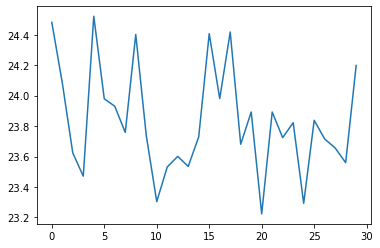

In [99]:
plt.plot(result)

In [178]:
params = {'bagging_fraction': 0.8532006036285371,
 'feature_fraction': 0.64842744223531,
 'lambda_l2': 0.8080489929934741,
 'learning_rate': 0.08690800978587224}

In [179]:
capacity = 1000
sun_radio_model = lgb.train(params, 
                           train_dataset, 
                           10000, 
                           val_dataset, 
                           feval= nmae_10_lgb, 
                           verbose_eval=500, 
                           early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 14
[LightGBM] [Info] Start training from score 0.517483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's score: 0.0486761


In [107]:
import joblib

joblib.dump(sun_radio_model,"sun_radio_model.pkl")

['sun_radio_model.pkl']

In [152]:
y_pred = sun_radio_model.predict(val_x)

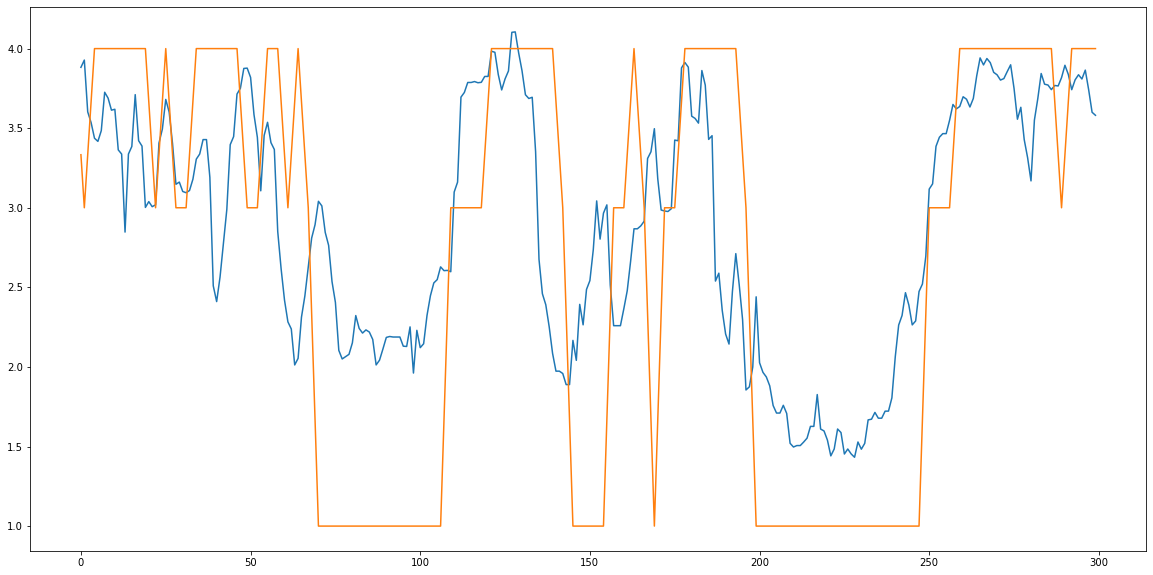

In [156]:
plt.figure(figsize = (20,10))
plt.plot(y_pred[200:500])
plt.plot(val_y[200:500])

#### - 울산

In [180]:
train_x, train_y, val_x, val_y = train_datast(ccc, 
                                              dangjin_fcst, 
                                              target='ulsan', 
                                              sun_target = "sun_ulsan",
                                             rain_target = "ulsan")

In [94]:
'''
train_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))
val_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

ae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

train_x = np.hstack([train_x, ae_result])

ae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

val_x = np.hstack([val_x, ae_result])
'''

'\ntrain_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\nval_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\n\ntrain_min_dangjin = -9\ntrain_max_dangjin = 100\n\ntrain_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\nval_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\n\nae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\ntrain_x = np.hstack([train_x, ae_result])\n\nae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\nval_x = np.hstack([val_x, ae_result])\n'

In [181]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [182]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = mean_squared_error
                     )

    global y_pred
    
    y_pred = model.predict(val_x)

    mae = mean_squared_error(val_y, y_pred)

    return 1/mae

In [191]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1),
            "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                    pbounds=params, 
                    verbose=2, 
                    random_state=250)


bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  1        |  17.97    |  0.2149   |  0.2727   |  0.3573   |  0.1238   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  17       |  20.88    |  0.137    |  0.4718   |  0.2325   |  0.07099  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  18       |  20.83    |  0.634    |  0.7314   |  0.5875   |  0.06496  |
[LightGBM] [Warning] Auto-choosing r

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  26       |  21.17    |  0.08359  |  0.5084   |  0.3198   |  0.09757  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  27       |  20.63    |  0.1649   |  0.4911   |  0.3175   |  0.07274  |
[LightGBM] [Warning] Auto-choosing r

|  37       |  19.84    |  0.4284   |  0.9272   |  0.8528   |  0.1892   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  38       |  12.38    |  0.5806   |  0.5017   |  0.9216   |  0.01578  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  39       |  17.73    |  0.0001   

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  50       |  21.39    |  0.05061  |  0.5546   |  0.3302   |  0.08841  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  51       |  20.15    |  0.6762   |  0.7281   |  0.5325   |  0.1435   |
[LightGBM] [Warning] Auto-choosing r

|  59       |  19.11    |  0.5549   |  0.6872   |  0.7479   |  0.1313   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  60       |  18.39    |  0.0131   |  0.5944   |  0.2546   |  0.1662   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  61       |  19.75    |  0.5046   

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  76       |  21.48    |  0.2136   |  0.6122   |  0.4161   |  0.1119   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  77       |  18.83    |  0.2644   |  0.5891   |  0.3968   |  0.02872  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  93       |  21.38    |  0.1384   |  0.6885   |  0.4061   |  0.08862  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  94       |  17.38    |  0.3277   |  0.4216   |  0.8064   |  0.04216  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  105      |  21.24    |  0.2358   |  0.7383   |  0.6664   |  0.1141   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  108      |  16.95    |  0.2399   |  0.7241   |  0.5983   |  0.1816   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  109      |  20.89    |  0.2385   |  0.7023   |  0.6804   |  0.0498   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  118      |  19.96    |  0.2301   |  0.7658   |  0.7588   |  0.1349   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  119      |  18.84    |  0.1336   |  0.8651   |  0.6985   |  0.1471   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  124      |  21.07    |  0.871    |  0.8704   |  0.633    |  0.0574   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  125      |  20.41    |  0.2138   |  0.7759   |  0.634    |  0.05182  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  136      |  20.4     |  1.0      |  0.8451   |  0.6878   |  0.0456   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  137      |  20.09    |  0.139    |  0.4684   |  0.2378   |  0.06556  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  142      |  18.44    |  0.08172  |  0.9801   |  0.6327   |  0.1978   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  143      |  20.85    |  0.268    |  0.4858   |  0.4573   |  0.06622  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  148      |  21.75    |  0.5959   |  0.662    |  0.3318   |  0.07827  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  149      |  19.46    |  0.5851   |  0.7041   |  0.3354   |  0.1135   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  160      |  21.47    |  0.3356   |  0.5608   |  0.4997   |  0.07289  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  161      |  18.13    |  0.1087   |  0.7856   |  0.4172   |  0.1256   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  167      |  19.16    |  0.626    |  0.6428   |  0.7452   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  168      |  21.85    |  0.1753   |  0.5994   |  0.3893   |  0.05392  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  182      |  19.58    |  0.3726   |  0.5373   |  0.3646   |  0.03468  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  183      |  20.66    |  0.3822   |  0.7001   |  0.3596   |  0.04405  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  193      |  22.26    |  0.5263   |  0.6252   |  0.08482  |  0.07447  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  194      |  19.53    |  0.2606   |  0.9588   |  0.9343   |  0.142    |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  200      |  21.34    |  0.5318   |  0.6008   |  0.01967  |  0.09275  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
|  201      |  19.07    |  0.3246   |  0.7933   |  0.06502  |  0.143    |
[LightGBM] [Warning] Auto-choosing r

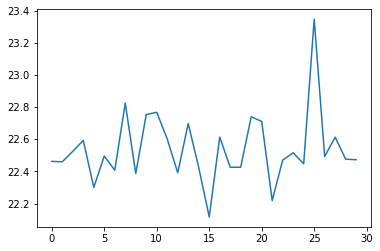

In [189]:
plt.plot(result)

In [190]:
result[25]

23.349635078003743

In [192]:
params = {'bagging_fraction': 0.27899374566613044,
 'feature_fraction': 0.5899890925573251,
 'lambda_l2': 0.49129300614732957,
 'learning_rate': 0.07728432511779665}

In [193]:
capacity = 1000
sun_radio_ulsan_model = lgb.train(params, 
                           train_dataset, 
                           10000, 
                           val_dataset, 
                           feval= nmae_10_lgb, 
                           verbose_eval=500, 
                           early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 76336, number of used features: 13
[LightGBM] [Info] Start training from score 0.517483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's score: 0.0427425


In [194]:
import joblib

joblib.dump(sun_radio_model,"sun_radio_ulsan_model.pkl")

['sun_radio_ulsan_model.pkl']

In [195]:
y_pred = sun_radio_model.predict(val_x)

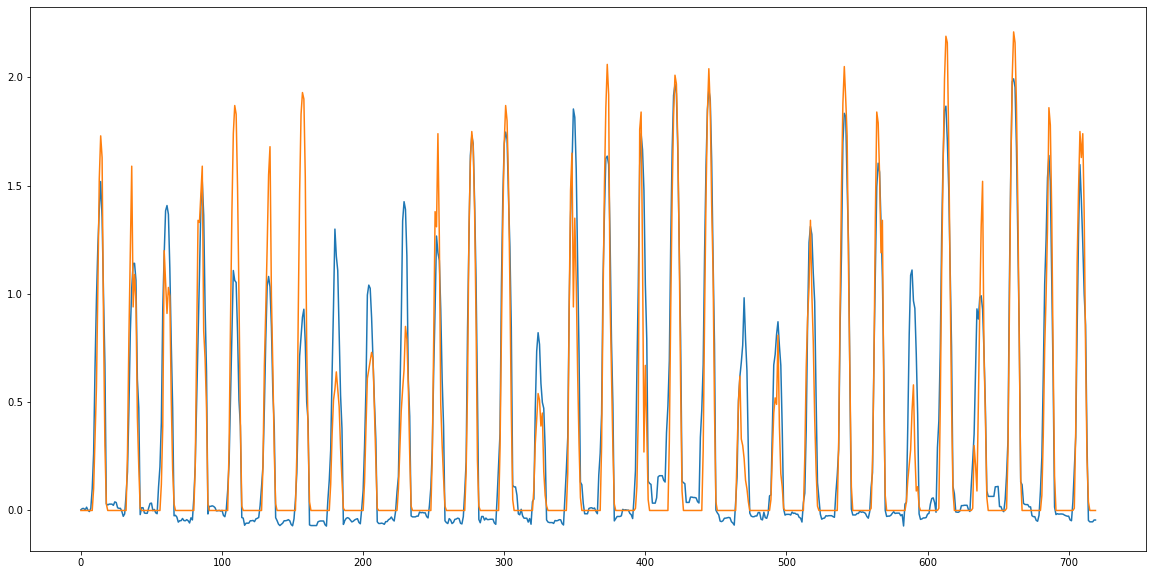

In [197]:
plt.figure(figsize = (20,10))
plt.plot(y_pred)
plt.plot(val_y)

## 2) 미세먼지

### (1) train-test 분할

In [821]:
concat_df.columns

Index(['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'Cloud',
       'Forecast time', 'PM10', 'date', 'hour', 'year', 'month', 'day',
       'WindDirection_0', 'WindDirection_1', 'WindDirection_2',
       'WindDirection_3', 'WindDirection_4', 'WindDirection_5',
       'WindDirection_6', 'WindDirection_7', 'sun_dangjin', 'sun_ulsan',
       'fall_prob_dangjin', 'fall_prob_ulsan', 'dangjin_type_0',
       'dangjin_type_1', 'dangjin_type_2', 'dangjin_type_3', 'dangjin_type_4',
       'ulsan_type_0', 'ulsan_type_1', 'ulsan_type_2', 'ulsan_type_3',
       'ulsan_type_4'],
      dtype='object')

In [834]:
def train_datast_dust(dust_df, fcst_df, target, sun_target, rain_target):
    # 일기 예보 있는 날짜만 선택
    
    dust = dust_df.copy()
    dust.index = range(dust.shape[0])
    dust.columns = ["Forecast time","PM10"]
    dust["Forecast_time"] = pd.to_datetime(dust["Forecast time"]).astype("str")

    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.copy()
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    
    concat_df = pd.merge(fcst, dust, on = "Forecast_time")
    
    start = '2015-03-02 00:00:00'
    end = '2021-01-01 00:00:00'
    
    start_idx = concat_df[concat_df['Forecast_time']==start].index[0]
    end_idx = concat_df[concat_df['Forecast_time']==end].index[0]
    
    concat_df = concat_df.loc[start_idx:end_idx, :].copy()
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    concat_df["WindDirection"] = concat_df["WindDirection"].apply(lambda x : direction_label(x)).astype(int)
    
    concat_df = pd.get_dummies(concat_df, prefix = "WindDirection", columns = ["WindDirection"])
    
    concat_df = pd.merge(concat_df, sun_result, how = "left")
    
    concat_df = pd.merge(concat_df, rain_14, how = "left")
    
    global feature_df
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 
                            'month', 
                            'day', 
                            'hour', 
                            'Temperature',
                            'Humidity', 
                            'WindSpeed', 
                            'Cloud',
                            '{}_type_0'.format(rain_target),
                            '{}_type_1'.format(rain_target),
                            '{}_type_2'.format(rain_target),
                            '{}_type_3'.format(rain_target),
                            '{}_type_4'.format(rain_target),
                            'fall_prob_{}'.format(rain_target),
                            sun_target,
                            'PM10']].drop_duplicates()
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    
    train_df = feature_df.iloc[:-24*30].dropna()
    val_df = feature_df.iloc[-24*30 - 1 :].dropna()
    
    train_x = train_df.loc[:, 'year':str(sun_target)].to_numpy()
    train_y = train_df[["year","month","day",'PM10']].to_numpy()
    
    val_x = val_df.loc[:, 'year':str(sun_target)].to_numpy()
    val_y = val_df[["year","month","day",'PM10']].to_numpy()
    
    return train_x, train_y, val_x, val_y

### (2) LGBM

#### - 당진

In [1235]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    
    return 'score', mae, False

In [1236]:
train_x, train_y, val_x, val_y = train_datast_dust(fine_dust_dangjin[["Forecast time","PM10"]], 
                                              dangjin_fcst, 
                                              target='dangjin', 
                                              sun_target = "sun_dangjin",
                                             rain_target = "dangjin")

In [1237]:
train_y = train_y[:,-1]
val_y = val_y[:,-1]

In [1212]:
'''
train_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))
val_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

ae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

train_x = np.hstack([train_x, ae_result])

ae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

val_x = np.hstack([val_x, ae_result])
'''

'\ntrain_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\nval_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\n\ntrain_min_dangjin = -9\ntrain_max_dangjin = 100\n\ntrain_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\nval_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\n\nae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\ntrain_x = np.hstack([train_x, ae_result])\n\nae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\nval_x = np.hstack([val_x, ae_result])\n'

In [1238]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [1239]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = sklearn.metrics.mean_absolute_error
                     )

    global y_pred
    
    y_pred = model.predict(val_x)

    mae = mean_squared_error(val_y, y_pred)

    return 1/mae

In [1240]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1),
            "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                    pbounds=params, 
                    verbose=2, 
                    random_state=80)


bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  1        |  0.002679 |  0.522    |  0.6994   |  0.2699   |  0.1349   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [In

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  11       |  0.002469 |  0.05706  |  0.8806   |  0.8852   |  0.164    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

|  16       |  0.002674 |  0.6042   |  0.3301   |  0.8461   |  0.04334  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

|  22       |  0.002641 |  0.08473  |  0.6992   |  0.3435   |  0.1401   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  23       |  0.002812 |  0.452    |  0.5712   |  0.04221  |  0.1161   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  24       |  0.002541 |  0.4079 

|  33       |  0.002648 |  0.6111   |  0.8841   |  0.1676   |  0.1258   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  34       |  0.00281  |  0.1702   |  0.7181   |  0.6363   |  0.02724  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  35       |  0.002098 |  0.6656 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  39       |  0.002657 |  0.08584  |  0.5825   |  0.1257   |  0.1427   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  48       |  0.002532 |  0.5382   |  0.6382   |  0.8143   |  0.1052   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  49       |  0.002505 |  0.8733   |  0.7129   |  0.5559   |  0.1988   |
[LightGBM] [Warning] Auto-choosing

|  55       |  0.002744 |  0.3256   |  0.9976   |  0.5151   |  0.007625 |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  60       |  0.002479 |  0.5385   |  0.8668   |  0.4528   |  0.1959   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  61       |  0.002679 |  0.7841   |  0.8401   |  0.005316 |  0.005962 |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  69       |  0.00274  |  0.1233   |  0.4165   |  0.1751   |  0.01629  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  70       |  0.002714 |  0.2755   |  0.4532   |  0.1805   |  0.1994   |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  79       |  0.00244  |  0.5862   |  0.8448   |  0.3864   |  0.191    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  80       |  0.002439 |  0.8509   |  0.8058   |  0.4363   |  0.1162   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  85       |  0.002059 |  0.3631   |  0.9288   |  0.6648   |  0.1879   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  86       |  0.002508 |  0.1805   |  0.3798   |  0.5938   |  0.1566   |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  99       |  0.002538 |  0.6087   |  0.6183   |  0.6766   |  0.1066   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  112      |  0.002441 |  0.9342   |  0.3893   |  0.6301   |  0.1479   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  113      |  0.002688 |  0.9966   |  0.2532   |  0.2358   |  0.1716   |
[LightGBM] [Warning] Auto-choosing row-wise multi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  118      |  0.002672 |  0.4822   |  0.5766   |  0.5473   |  0.1516   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  127      |  0.002507 |  0.2366   |  0.6052   |  0.3799   |  0.1686   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  128      |  0.002838 |  0.4102   |  0.4395   |  0.5456   |  0.1745   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  137      |  0.002671 |  0.6013   |  0.2932   |  0.198    |  0.07849  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  142      |  0.002732 |  0.7339   |  0.7535   |  0.5977   |  0.02024  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  143      |  0.002616 |  0.9045   |  0.5511   |  0.929    |  0.07902  |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  152      |  0.002623 |  0.8767   |  0.4576   |  0.2026   |  0.06508  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  153      |  0.002616 |  0.7975   |  0.3677   |  0.4246   |  0.1242   |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  161      |  0.002581 |  0.5642   |  0.646    |  0.9389   |  0.1254   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  162      |  0.002419 |  0.6555   |  0.5957   |  0.3338   |  0.09892  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  166      |  0.002645 |  0.391    |  0.6263   |  0.7978   |  0.008246 |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  167      |  0.002782 |  0.7065   |  0.6264   |  0.4133   |  0.03776  |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  171      |  0.002766 |  0.8116   |  0.5938   |  0.7498   |  0.01644  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  172      |  0.002613 |  0.81     |  0.3787   |  0.07004  |  0.08142  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  178      |  0.00265  |  0.849    |  0.7967   |  0.8445   |  0.1148   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  187      |  0.002796 |  0.9375   |  0.3132   |  0.635    |  0.1178   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  195      |  0.002117 |  0.06217  |  0.9906   |  0.1702   |  0.1962   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
|  196      |  0.002555 |  0.8066   |  0.6963   |  0.8718   |  0.1498   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  200      |  0.002692 |  0.6623   |  0.3193   |  0.5168   |  0.1928   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [

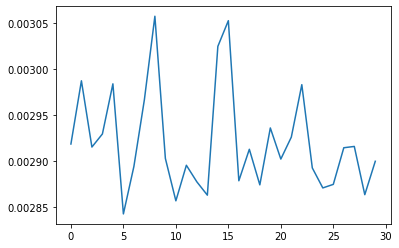

In [1229]:
plt.plot(result_1)

In [1233]:
result_1[8]

0.003057055181762737

In [1245]:
params = {'bagging_fraction': 0.41020216462053993,
 'feature_fraction': 0.5581894737053765,
 'lambda_l2': 0.3966173309760741,
 'learning_rate': 0.06895846652196458}

In [1244]:
capacity = 1000
fine_dust_dangjin_model = lgb.train(params, 
                           train_dataset, 
                           10000, 
                           val_dataset, 
                           feval= nmae_10_lgb, 
                           verbose_eval=500, 
                           early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 45385, number of used features: 14
[LightGBM] [Info] Start training from score 40.555161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's score: 12.3417


In [1246]:
import joblib

joblib.dump(fine_dust_dangjin_model,"fine_dust_dangjin_model.pkl")

['fine_dust_dangjin_model.pkl']

In [1247]:
y_pred = fine_dust_dangjin_model.predict(val_x)

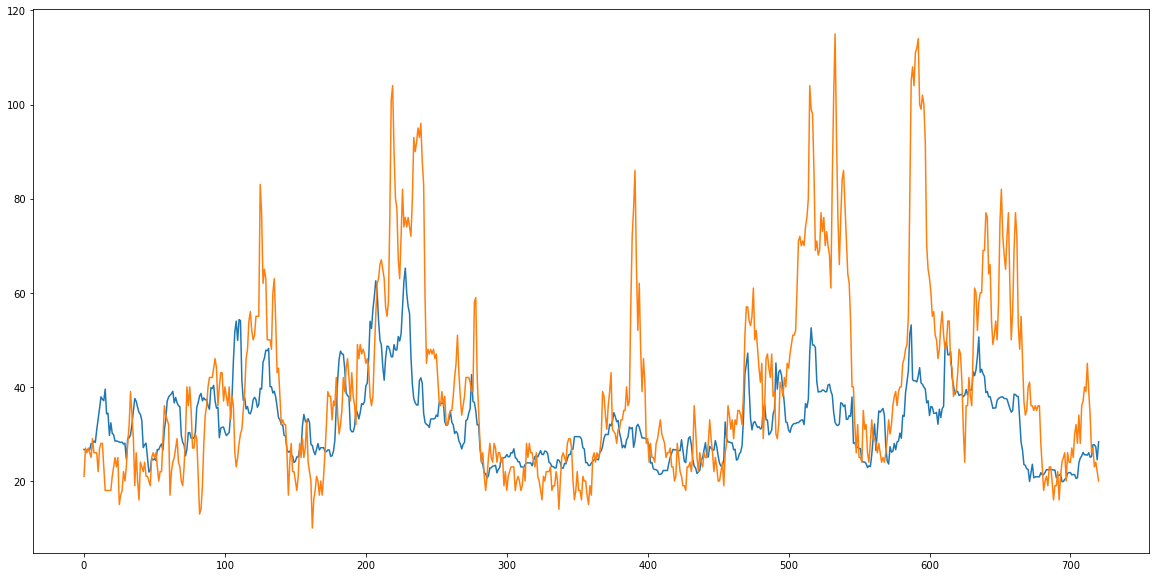

In [1248]:
plt.figure(figsize = (20,10))
plt.plot(y_pred)
plt.plot(val_y)

In [1179]:
np.corrcoef(y_pred, val_y)

array([[1.        , 0.60895215],
       [0.60895215, 1.        ]])

In [1201]:
DataFrame(fine_dust_dangjin_model.feature_importance(),
          ['year', 
           'month', 
            'day', 
            'hour', 
            'Temperature',
            'Humidity', 
            'WindSpeed', 
            'Cloud',
            'type_0',
            'type_1',
            'type_2',
            'type_3',
            'type_4',
            'fall_prob',
             "sun_radio"])

,0
year,277
month,359
day,465
hour,121
Temperature,289
Humidity,274
WindSpeed,279
Cloud,162
type_0,9
type_1,13


#### - 울산

In [1249]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    
    return 'score', mae, False

In [1250]:
train_x, train_y, val_x, val_y = train_datast_dust(fine_dust_ulsan[["Forecast time","PM10"]], 
                                              dangjin_fcst, 
                                              target='ulsan', 
                                              sun_target = "sun_ulsan",
                                             rain_target = "ulsan")

In [1251]:
train_y = train_y[:,-1]
val_y = val_y[:,-1]

In [335]:
'''
train_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))
val_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

ae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

train_x = np.hstack([train_x, ae_result])

ae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

val_x = np.hstack([val_x, ae_result])
'''

'\ntrain_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\nval_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))\n\ntrain_min_dangjin = -9\ntrain_max_dangjin = 100\n\ntrain_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\nval_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)\n\nae_result = Auto_Encoder_dangjin(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\ntrain_x = np.hstack([train_x, ae_result])\n\nae_result = Auto_Encoder_dangjin(val_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin\n\nval_x = np.hstack([val_x, ae_result])\n'

In [1252]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [1253]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = sklearn.metrics.mean_absolute_error
                     )

    global y_pred
    
    y_pred = model.predict(val_x)

    mae = mean_squared_error(val_y, y_pred)

    return 1/mae

In [1258]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1),
            "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                    pbounds=params, 
                    verbose=2, 
                    random_state=240)


bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  1        |  0.003697 |  0.2936   |  0.4304   |  0.7837   |  0.04886  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  7        |  0.003396 |  0.9126   |  0.2649   |  0.2021   |  0.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  16       |  0.003939 |  0.6063   |  0.7582   |  0.2204   |  0.1393   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

|  23       |  0.003647 |  0.000369 |  0.9883   |  0.5185   |  0.1173   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  29       |  0.003632 |  0.9966   |  0.5128   |  0.01288  |  0.05798  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  30       |  0.003585 |  0.6705   |  0.9881   |  0.5009   |  0.1919   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

|  34       |  0.003534 |  0.6089   |  0.7913   |  0.6678   |  0.1156   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  35       |  0.00371  |  0.6384   |  0.5776   |  0.7788   |  0.1932   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
[LightGBM] [Warning] No further 

|  47       |  0.003558 |  0.6419   |  0.4472   |  0.02502  |  0.1916   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  48       |  0.003657 |  0.01783  |  0.506    |  0.661    |  0.06082  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  49       |  0.003447 |  0.411

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  60       |  0.003508 |  0.01394  |  0.6211   |  0.9858   |  0.1787   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  61       |  0.003353 |  0.5911   |  0.9288   |  0.001938 |  0.01564  |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  66       |  0.00289  |  0.03346  |  0.4743   |  0.02626  |  0.007051 |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  67       |  0.003678 |  0.3074   |  0.9782   |  0.9933   |  0.1854   |
[LightGBM] [Warning] Auto-choosi

|  73       |  0.003713 |  0.2758   |  0.6547   |  0.000488 |  0.1937   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  74       |  0.003203 |  0.9239   |  0.7569   |  0.02236  |  0.01114  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  75       |  0.002842 |  0.272

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  89       |  0.003203 |  0.1628   |  0.3384   |  0.6803   |  0.1367   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  90       |  0.003957 |  0.6405   |  0.7653   |  0.2572   |  0.1779   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  103      |  0.003687 |  0.3486   |  0.9912   |  0.9158   |  0.1633   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  104      |  0.003666 |  0.6587   |  0.8098   |  0.2987   |  0.1591   |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  115      |  0.003346 |  0.9827   |  0.1872   |  0.1924   |  0.04642  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  116      |  0.003751 |  0.2034   |  0.7038   |  0.7125   |  0.0549   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  131      |  0.003613 |  0.9993   |  0.4987   |  0.006338 |  0.05983  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  132      |  0.003814 |  0.4034   |  0.8798   |  0.5324   |  0.1821   |
[LightGBM] [Warning] Auto-choosi

|  141      |  0.00362  |  0.3458   |  0.5979   |  0.8789   |  0.196    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  142      |  0.003435 |  0.4368   |  0.8409   |  0.4199   |  0.01932  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  143      |  0.003593 |  0.407

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  155      |  0.003889 |  0.9674   |  0.816    |  0.6819   |  0.09352  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  156      |  0.003792 |  0.6911   |  0.8924   |  0.2695   |  0.09323  |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  161      |  0.003711 |  0.6403   |  0.9141   |  0.1401   |  0.1158   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  162      |  0.00336  |  0.7377   |  0.8847   |  0.2507   |  0.01644  |
[LightGBM] [Warning] Auto-choosi

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  169      |  0.003804 |  0.5452   |  0.7426   |  0.4155   |  0.07982  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  170      |  0.003746 |  0.5072   |  0.9852   |  0.4545   |  0.09909  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  181      |  0.003922 |  0.4144   |  0.972    |  0.7082   |  0.1602   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  182      |  0.003948 |  0.9768   |  0.9365   |  0.9568   |  0.166    |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  194      |  0.002542 |  0.4905   |  0.5938   |  0.4513   |  0.001118 |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
|  195      |  0.003801 |  0.3669   |  0.915    |  0.8515   |  0.05796  |
[LightGBM] [Warning] Auto-choosi

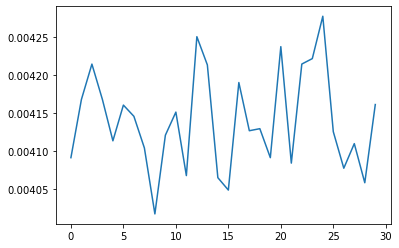

In [1254]:
plt.plot(result_2)

In [1256]:
result_2[24]

0.004277418159210076

In [1259]:
params = {'bagging_fraction': 0.3064309327445396,
 'feature_fraction': 0.9841153868091663,
 'lambda_l2': 0.9845686559036195,
 'learning_rate': 0.19150635302926877}

In [1260]:
capacity = 1000
fine_dust_ulsan_model = lgb.train(params, 
                           train_dataset, 
                           10000, 
                           val_dataset, 
                           feval= nmae_10_lgb, 
                           verbose_eval=500, 
                           early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 45241, number of used features: 13
[LightGBM] [Info] Start training from score 42.689253
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	valid_0's score: 10.382


In [1261]:
import joblib

joblib.dump(fine_dust_ulsan_model,"fine_dust_ulsan_model.pkl")

['fine_dust_ulsan_model.pkl']

In [1262]:
y_pred = fine_dust_ulsan_model.predict(val_x)

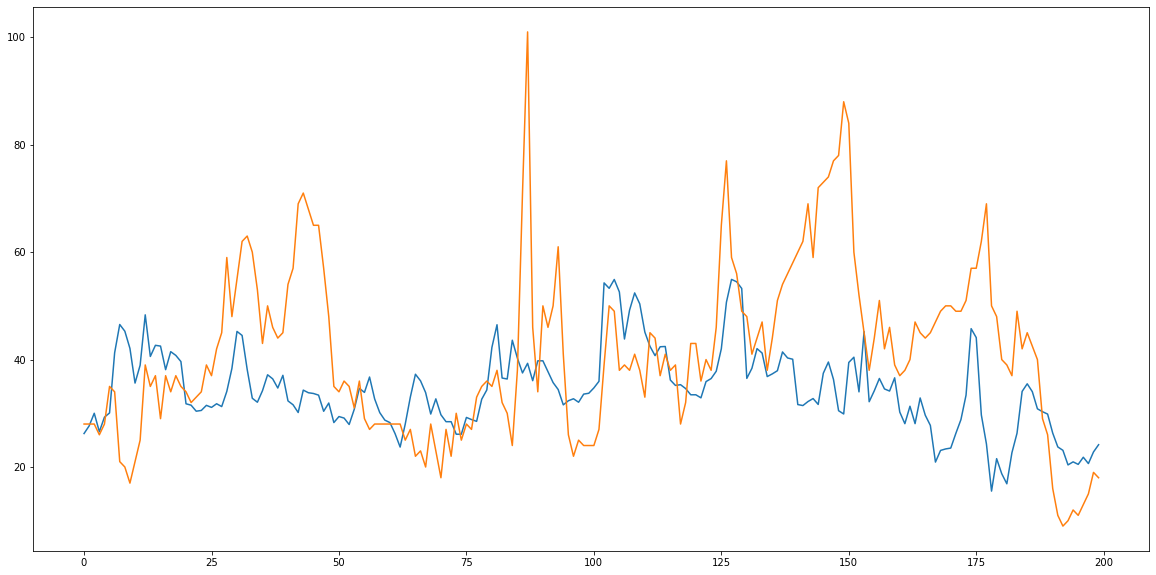

In [1263]:
plt.figure(figsize = (20,10))
plt.plot(y_pred[100:300])
plt.plot(val_y[100:300])

In [1264]:
np.corrcoef(y_pred, val_y)

array([[1.        , 0.56549797],
       [0.56549797, 1.        ]])

In [ ]:
['year', 
'month', 
'day', 
'hour', 
'Temperature',
'Humidity', 
'WindSpeed', 
'Cloud',
'type_0',
'type_1',
'type_2',
'type_3',
'type_4',
'fall_prob',
 "sun_radio"]

In [1200]:
DataFrame(fine_dust_ulsan_model.feature_importance(),
          ['year', 
           'month', 
            'day', 
            'hour', 
            'Temperature',
            'Humidity', 
            'WindSpeed', 
            'Cloud',
            'type_0',
            'type_1',
            'type_2',
            'type_3',
            'type_4',
            'fall_prob',
             "sun_radio"])

,0
year,517
month,481
day,992
hour,278
Temperature,556
Humidity,415
WindSpeed,537
Cloud,267
type_0,3
type_1,2


## 2) NN

In [1015]:
train_x, train_y, val_x, val_y = train_datast_dust(fine_dust_dangjin[["Forecast time","PM10"]], 
                                              dangjin_fcst, 
                                              target='dangjin', 
                                              sun_target = "sun_dangjin",
                                             rain_target = "dangjin")

In [1016]:
train_x = train_x[:-1]
train_y = train_y[:-1]
val_x = val_x[:-1]
val_y = val_y[:-1]

In [1017]:
train_x = np.stack(DataFrame(train_x).groupby([0,1,2]).apply(lambda x : np.array(x)))
val_x = np.stack(DataFrame(val_x).groupby([0,1,2]).apply(lambda x : np.array(x)))

In [1018]:
train_y = np.stack(DataFrame(train_y).groupby([0,1,2]).apply(lambda x : np.array(x[3])))
val_y = np.stack(DataFrame(val_y).groupby([0,1,2]).apply(lambda x : np.array(x[3])))

In [1019]:
train_x[:,:,0] = np.array(DataFrame(train_x[:,:,0]).astype("str").apply(lambda x : x.str.slice(2,4).astype("int")))
val_x[:,:,0] = np.array(DataFrame(val_x[:,:,0]).astype("str").apply(lambda x : x.str.slice(2,4).astype("int")))

train_max_dangjin = np.max(train_x)
train_min_dangjin = np.min(train_x)

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_x_scaled = (np.array(val_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [1020]:
train_y_scaled = (np.array(train_y) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)
val_y_scaled = (np.array(val_y) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [1042]:
class auto_encoder_lstm(tf.keras.Model):
    def __init__(self, 
                 lstm_dim,
                input_dim,
                output_dense):
        
        super(auto_encoder_lstm, self).__init__()
        
        self.lstm_dim = lstm_dim
        
        self.input_dim = input_dim
        
        self.output_dense = output_dense
     
    def build(self, input_shape):
        
        self.dense = tf.keras.layers.Dense(self.input_dim,
                                          activation = "relu")
        
        self.dense_2 = tf.keras.layers.Dense(self.input_dim,
                                           activation = "relu")
        
        self.dense_3 = tf.keras.layers.Dense(self.input_dim,
                                   activation = "relu")
        
        self.dense_4 = tf.keras.layers.Dense(self.input_dim,
                           activation = "relu")
        
        self.dense_5 = tf.keras.layers.Dense(self.input_dim,
                           activation = "relu")
        
        self.dropout = tf.keras.layers.Dropout(0.2)

        self.lstm = tf.keras.layers.LSTM(self.lstm_dim,
                                        return_sequences = True)
        
        output_layer = tf.keras.layers.Dense(self.output_dense, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        
        dense_output = self.dense(input_tensor)
        
        dense_output = self.dense_2(dense_output)
        
        #dense_output = self.dense_3(dense_output)
        
        #dense_output = self.dense_4(dense_output)
        
        desne_output = self.dropout(dense_output)
        
        dense_output = self.dense_5(dense_output)
        
        lstm_output = self.lstm(dense_output)
        
        output = self.outputs(lstm_output)
        
        return output

In [1043]:
AE = auto_encoder_lstm(200, 100, 100)

In [1104]:
@tf.function()
def training_LSTM(inp , tar):
    with tf.GradientTape() as tape:
        
        output = AE(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, AE.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, 
                                     output * (train_max_dangjin - train_min_dangjin) + train_min_dangjin))

In [1105]:
def val_accuracy(inp, tar):
    
    tar = tf.expand_dims(tar, -1)
    
    result = accuracy_function(inp * (train_max_dangjin - train_min_dangjin) + train_min_dangjin
                               , tar)
    
    test_accuracy(result)

In [1106]:
EPOCHS = 1000
batch_size = 50

In [1107]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanAbsoluteError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = train_x_scaled[(i - 1) * batch_size : (i * batch_size)].copy()
        inp = tf.Variable(inp, dtype = tf.float32)
        
        tar = tf.Variable(train_y_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.expand_dims(tar, -1)

        i += 1

        training_LSTM(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(train_x_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(val_x_scaled, val_y)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.0459 Accuracy 5.4821
Epoch 1 Batch 10 Loss 0.0453 Accuracy 5.2670
Epoch 1 Batch 15 Loss 0.0458 Accuracy 5.2038
Epoch 1 Batch 20 Loss 0.0435 Accuracy 5.1731
Epoch 1 Batch 25 Loss 0.0420 Accuracy 5.1168
Epoch 1 Batch 30 Loss 0.0412 Accuracy 5.0468
Epoch 1 Batch 35 Loss 0.0409 Accuracy 4.9926
Time taken for 1 epoch: 1.40 secs

TestLoss 0.0000 TestAccuracy 5.0898
Epoch 2 Batch 5 Loss 0.0415 Accuracy 4.9809
Epoch 2 Batch 10 Loss 0.0420 Accuracy 4.9986
Epoch 2 Batch 15 Loss 0.0424 Accuracy 5.0120
Epoch 2 Batch 20 Loss 0.0422 Accuracy 5.0248
Epoch 2 Batch 25 Loss 0.0418 Accuracy 5.0300
Epoch 2 Batch 30 Loss 0.0415 Accuracy 5.0281
Epoch 2 Batch 35 Loss 0.0414 Accuracy 5.0238
Time taken for 1 epoch: 0.41 secs

TestLoss 0.0000 TestAccuracy 5.1184
Epoch 3 Batch 5 Loss 0.0415 Accuracy 5.0271
Epoch 3 Batch 10 Loss 0.0416 Accuracy 5.0345
Epoch 3 Batch 15 Loss 0.0415 Accuracy 5.0391
Epoch 3 Batch 20 Loss 0.0413 Accuracy 5.0422
Epoch 3 Batch 25 Loss 0.0410 Accuracy 5.0427
Epoch 

Epoch 22 Batch 15 Loss 0.0416 Accuracy 5.1107
Epoch 22 Batch 20 Loss 0.0416 Accuracy 5.1112
Epoch 22 Batch 25 Loss 0.0415 Accuracy 5.1116
Epoch 22 Batch 30 Loss 0.0415 Accuracy 5.1120
Epoch 22 Batch 35 Loss 0.0415 Accuracy 5.1124
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 5.1386
Epoch 23 Batch 5 Loss 0.0416 Accuracy 5.1130
Epoch 23 Batch 10 Loss 0.0416 Accuracy 5.1135
Epoch 23 Batch 15 Loss 0.0416 Accuracy 5.1139
Epoch 23 Batch 20 Loss 0.0415 Accuracy 5.1143
Epoch 23 Batch 25 Loss 0.0415 Accuracy 5.1147
Epoch 23 Batch 30 Loss 0.0415 Accuracy 5.1151
Epoch 23 Batch 35 Loss 0.0415 Accuracy 5.1154
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1407
Epoch 24 Batch 5 Loss 0.0415 Accuracy 5.1160
Epoch 24 Batch 10 Loss 0.0416 Accuracy 5.1164
Epoch 24 Batch 15 Loss 0.0416 Accuracy 5.1168
Epoch 24 Batch 20 Loss 0.0416 Accuracy 5.1172
Epoch 24 Batch 25 Loss 0.0415 Accuracy 5.1176
Epoch 24 Batch 30 Loss 0.0415 Accuracy 5.1179
Epoch 24 Batch 35 Loss 0.0416 Ac

Epoch 43 Batch 25 Loss 0.0441 Accuracy 5.2110
Epoch 43 Batch 30 Loss 0.0441 Accuracy 5.2119
Epoch 43 Batch 35 Loss 0.0441 Accuracy 5.2127
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 5.2316
Epoch 44 Batch 5 Loss 0.0442 Accuracy 5.2139
Epoch 44 Batch 10 Loss 0.0442 Accuracy 5.2147
Epoch 44 Batch 15 Loss 0.0442 Accuracy 5.2156
Epoch 44 Batch 20 Loss 0.0442 Accuracy 5.2164
Epoch 44 Batch 25 Loss 0.0442 Accuracy 5.2172
Epoch 44 Batch 30 Loss 0.0442 Accuracy 5.2181
Epoch 44 Batch 35 Loss 0.0442 Accuracy 5.2189
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 5.2376
Epoch 45 Batch 5 Loss 0.0442 Accuracy 5.2200
Epoch 45 Batch 10 Loss 0.0443 Accuracy 5.2209
Epoch 45 Batch 15 Loss 0.0443 Accuracy 5.2217
Epoch 45 Batch 20 Loss 0.0443 Accuracy 5.2226
Epoch 45 Batch 25 Loss 0.0443 Accuracy 5.2234
Epoch 45 Batch 30 Loss 0.0443 Accuracy 5.2242
Epoch 45 Batch 35 Loss 0.0443 Accuracy 5.2250
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 5.2434
Epoch 4

Epoch 64 Batch 30 Loss 0.0436 Accuracy 5.2941
Epoch 64 Batch 35 Loss 0.0436 Accuracy 5.2943
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.3074
Epoch 65 Batch 5 Loss 0.0436 Accuracy 5.2947
Epoch 65 Batch 10 Loss 0.0436 Accuracy 5.2950
Epoch 65 Batch 15 Loss 0.0436 Accuracy 5.2953
Epoch 65 Batch 20 Loss 0.0436 Accuracy 5.2955
Epoch 65 Batch 25 Loss 0.0436 Accuracy 5.2958
Epoch 65 Batch 30 Loss 0.0436 Accuracy 5.2960
Epoch 65 Batch 35 Loss 0.0436 Accuracy 5.2963
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.3091
Epoch 66 Batch 5 Loss 0.0436 Accuracy 5.2967
Epoch 66 Batch 10 Loss 0.0436 Accuracy 5.2969
Epoch 66 Batch 15 Loss 0.0436 Accuracy 5.2972
Epoch 66 Batch 20 Loss 0.0436 Accuracy 5.2974
Epoch 66 Batch 25 Loss 0.0436 Accuracy 5.2977
Epoch 66 Batch 30 Loss 0.0436 Accuracy 5.2979
Epoch 66 Batch 35 Loss 0.0436 Accuracy 5.2982
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.3108
Epoch 67 Batch 5 Loss 0.0436 Accuracy 5.2985
Epoch 67

Epoch 86 Batch 5 Loss 0.0431 Accuracy 5.3172
Epoch 86 Batch 10 Loss 0.0431 Accuracy 5.3173
Epoch 86 Batch 15 Loss 0.0431 Accuracy 5.3174
Epoch 86 Batch 20 Loss 0.0431 Accuracy 5.3175
Epoch 86 Batch 25 Loss 0.0431 Accuracy 5.3175
Epoch 86 Batch 30 Loss 0.0431 Accuracy 5.3176
Epoch 86 Batch 35 Loss 0.0431 Accuracy 5.3177
Time taken for 1 epoch: 0.41 secs

TestLoss 0.0000 TestAccuracy 5.3274
Epoch 87 Batch 5 Loss 0.0431 Accuracy 5.3178
Epoch 87 Batch 10 Loss 0.0431 Accuracy 5.3178
Epoch 87 Batch 15 Loss 0.0431 Accuracy 5.3179
Epoch 87 Batch 20 Loss 0.0431 Accuracy 5.3180
Epoch 87 Batch 25 Loss 0.0430 Accuracy 5.3180
Epoch 87 Batch 30 Loss 0.0430 Accuracy 5.3181
Epoch 87 Batch 35 Loss 0.0430 Accuracy 5.3182
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.3278
Epoch 88 Batch 5 Loss 0.0430 Accuracy 5.3182
Epoch 88 Batch 10 Loss 0.0430 Accuracy 5.3183
Epoch 88 Batch 15 Loss 0.0430 Accuracy 5.3184
Epoch 88 Batch 20 Loss 0.0430 Accuracy 5.3184
Epoch 88 Batch 25 Loss 0.0430 Acc


TestLoss 0.0000 TestAccuracy 5.3252
Epoch 107 Batch 5 Loss 0.0422 Accuracy 5.3174
Epoch 107 Batch 10 Loss 0.0422 Accuracy 5.3173
Epoch 107 Batch 15 Loss 0.0422 Accuracy 5.3173
Epoch 107 Batch 20 Loss 0.0422 Accuracy 5.3172
Epoch 107 Batch 25 Loss 0.0422 Accuracy 5.3172
Epoch 107 Batch 30 Loss 0.0422 Accuracy 5.3171
Epoch 107 Batch 35 Loss 0.0422 Accuracy 5.3170
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.3247
Epoch 108 Batch 5 Loss 0.0422 Accuracy 5.3169
Epoch 108 Batch 10 Loss 0.0422 Accuracy 5.3169
Epoch 108 Batch 15 Loss 0.0422 Accuracy 5.3168
Epoch 108 Batch 20 Loss 0.0422 Accuracy 5.3167
Epoch 108 Batch 25 Loss 0.0422 Accuracy 5.3167
Epoch 108 Batch 30 Loss 0.0422 Accuracy 5.3166
Epoch 108 Batch 35 Loss 0.0422 Accuracy 5.3165
Time taken for 1 epoch: 0.41 secs

TestLoss 0.0000 TestAccuracy 5.3241
Epoch 109 Batch 5 Loss 0.0422 Accuracy 5.3164
Epoch 109 Batch 10 Loss 0.0422 Accuracy 5.3164
Epoch 109 Batch 15 Loss 0.0422 Accuracy 5.3163
Epoch 109 Batch 20 Loss 0

Epoch 127 Batch 35 Loss 0.0420 Accuracy 5.3064
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.3130
Epoch 128 Batch 5 Loss 0.0420 Accuracy 5.3063
Epoch 128 Batch 10 Loss 0.0420 Accuracy 5.3063
Epoch 128 Batch 15 Loss 0.0420 Accuracy 5.3062
Epoch 128 Batch 20 Loss 0.0420 Accuracy 5.3061
Epoch 128 Batch 25 Loss 0.0420 Accuracy 5.3061
Epoch 128 Batch 30 Loss 0.0420 Accuracy 5.3060
Epoch 128 Batch 35 Loss 0.0420 Accuracy 5.3059
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.3124
Epoch 129 Batch 5 Loss 0.0420 Accuracy 5.3058
Epoch 129 Batch 10 Loss 0.0420 Accuracy 5.3057
Epoch 129 Batch 15 Loss 0.0419 Accuracy 5.3057
Epoch 129 Batch 20 Loss 0.0419 Accuracy 5.3056
Epoch 129 Batch 25 Loss 0.0419 Accuracy 5.3055
Epoch 129 Batch 30 Loss 0.0419 Accuracy 5.3054
Epoch 129 Batch 35 Loss 0.0419 Accuracy 5.3054
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.3118
Epoch 130 Batch 5 Loss 0.0419 Accuracy 5.3053
Epoch 130 Batch 10 Loss 0.0419 Accurac

Epoch 148 Batch 15 Loss 0.0414 Accuracy 5.2928
Epoch 148 Batch 20 Loss 0.0414 Accuracy 5.2926
Epoch 148 Batch 25 Loss 0.0414 Accuracy 5.2925
Epoch 148 Batch 30 Loss 0.0414 Accuracy 5.2924
Epoch 148 Batch 35 Loss 0.0414 Accuracy 5.2923
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.2978
Epoch 149 Batch 5 Loss 0.0414 Accuracy 5.2921
Epoch 149 Batch 10 Loss 0.0414 Accuracy 5.2920
Epoch 149 Batch 15 Loss 0.0414 Accuracy 5.2919
Epoch 149 Batch 20 Loss 0.0414 Accuracy 5.2918
Epoch 149 Batch 25 Loss 0.0414 Accuracy 5.2917
Epoch 149 Batch 30 Loss 0.0413 Accuracy 5.2916
Epoch 149 Batch 35 Loss 0.0413 Accuracy 5.2915
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.2970
Epoch 150 Batch 5 Loss 0.0413 Accuracy 5.2913
Epoch 150 Batch 10 Loss 0.0413 Accuracy 5.2912
Epoch 150 Batch 15 Loss 0.0413 Accuracy 5.2911
Epoch 150 Batch 20 Loss 0.0413 Accuracy 5.2910
Epoch 150 Batch 25 Loss 0.0413 Accuracy 5.2909
Epoch 150 Batch 30 Loss 0.0413 Accuracy 5.2908
Epoch 150 Batc

Epoch 169 Batch 10 Loss 0.0408 Accuracy 5.2735
Epoch 169 Batch 15 Loss 0.0407 Accuracy 5.2734
Epoch 169 Batch 20 Loss 0.0407 Accuracy 5.2733
Epoch 169 Batch 25 Loss 0.0407 Accuracy 5.2731
Epoch 169 Batch 30 Loss 0.0407 Accuracy 5.2730
Epoch 169 Batch 35 Loss 0.0407 Accuracy 5.2728
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.2776
Epoch 170 Batch 5 Loss 0.0407 Accuracy 5.2726
Epoch 170 Batch 10 Loss 0.0407 Accuracy 5.2725
Epoch 170 Batch 15 Loss 0.0407 Accuracy 5.2724
Epoch 170 Batch 20 Loss 0.0407 Accuracy 5.2722
Epoch 170 Batch 25 Loss 0.0407 Accuracy 5.2721
Epoch 170 Batch 30 Loss 0.0407 Accuracy 5.2719
Epoch 170 Batch 35 Loss 0.0407 Accuracy 5.2718
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.2765
Epoch 171 Batch 5 Loss 0.0407 Accuracy 5.2716
Epoch 171 Batch 10 Loss 0.0407 Accuracy 5.2715
Epoch 171 Batch 15 Loss 0.0407 Accuracy 5.2713
Epoch 171 Batch 20 Loss 0.0407 Accuracy 5.2712
Epoch 171 Batch 25 Loss 0.0407 Accuracy 5.2711
Epoch 171 Batc

Epoch 190 Batch 5 Loss 0.0404 Accuracy 5.2521
Epoch 190 Batch 10 Loss 0.0404 Accuracy 5.2520
Epoch 190 Batch 15 Loss 0.0404 Accuracy 5.2518
Epoch 190 Batch 20 Loss 0.0404 Accuracy 5.2517
Epoch 190 Batch 25 Loss 0.0404 Accuracy 5.2515
Epoch 190 Batch 30 Loss 0.0404 Accuracy 5.2514
Epoch 190 Batch 35 Loss 0.0404 Accuracy 5.2513
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.2555
Epoch 191 Batch 5 Loss 0.0404 Accuracy 5.2511
Epoch 191 Batch 10 Loss 0.0404 Accuracy 5.2509
Epoch 191 Batch 15 Loss 0.0404 Accuracy 5.2508
Epoch 191 Batch 20 Loss 0.0403 Accuracy 5.2507
Epoch 191 Batch 25 Loss 0.0403 Accuracy 5.2505
Epoch 191 Batch 30 Loss 0.0403 Accuracy 5.2504
Epoch 191 Batch 35 Loss 0.0403 Accuracy 5.2502
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.2544
Epoch 192 Batch 5 Loss 0.0403 Accuracy 5.2501
Epoch 192 Batch 10 Loss 0.0403 Accuracy 5.2499
Epoch 192 Batch 15 Loss 0.0403 Accuracy 5.2498
Epoch 192 Batch 20 Loss 0.0403 Accuracy 5.2496
Epoch 192 Batch

Epoch 211 Batch 5 Loss 0.0400 Accuracy 5.2303
Epoch 211 Batch 10 Loss 0.0400 Accuracy 5.2302
Epoch 211 Batch 15 Loss 0.0400 Accuracy 5.2300
Epoch 211 Batch 20 Loss 0.0400 Accuracy 5.2299
Epoch 211 Batch 25 Loss 0.0400 Accuracy 5.2298
Epoch 211 Batch 30 Loss 0.0400 Accuracy 5.2296
Epoch 211 Batch 35 Loss 0.0400 Accuracy 5.2295
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.2332
Epoch 212 Batch 5 Loss 0.0400 Accuracy 5.2293
Epoch 212 Batch 10 Loss 0.0400 Accuracy 5.2292
Epoch 212 Batch 15 Loss 0.0400 Accuracy 5.2290
Epoch 212 Batch 20 Loss 0.0400 Accuracy 5.2289
Epoch 212 Batch 25 Loss 0.0400 Accuracy 5.2288
Epoch 212 Batch 30 Loss 0.0399 Accuracy 5.2286
Epoch 212 Batch 35 Loss 0.0399 Accuracy 5.2285
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.2322
Epoch 213 Batch 5 Loss 0.0399 Accuracy 5.2283
Epoch 213 Batch 10 Loss 0.0399 Accuracy 5.2281
Epoch 213 Batch 15 Loss 0.0399 Accuracy 5.2280
Epoch 213 Batch 20 Loss 0.0399 Accuracy 5.2279
Epoch 213 Batch

Epoch 231 Batch 25 Loss 0.0398 Accuracy 5.2097
Epoch 231 Batch 30 Loss 0.0398 Accuracy 5.2096
Epoch 231 Batch 35 Loss 0.0398 Accuracy 5.2094
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 5.2129
Epoch 232 Batch 5 Loss 0.0398 Accuracy 5.2093
Epoch 232 Batch 10 Loss 0.0398 Accuracy 5.2091
Epoch 232 Batch 15 Loss 0.0398 Accuracy 5.2090
Epoch 232 Batch 20 Loss 0.0398 Accuracy 5.2089
Epoch 232 Batch 25 Loss 0.0398 Accuracy 5.2088
Epoch 232 Batch 30 Loss 0.0398 Accuracy 5.2086
Epoch 232 Batch 35 Loss 0.0398 Accuracy 5.2085
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 5.2119
Epoch 233 Batch 5 Loss 0.0397 Accuracy 5.2083
Epoch 233 Batch 10 Loss 0.0397 Accuracy 5.2082
Epoch 233 Batch 15 Loss 0.0397 Accuracy 5.2081
Epoch 233 Batch 20 Loss 0.0397 Accuracy 5.2079
Epoch 233 Batch 25 Loss 0.0397 Accuracy 5.2078
Epoch 233 Batch 30 Loss 0.0397 Accuracy 5.2077
Epoch 233 Batch 35 Loss 0.0397 Accuracy 5.2076
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccura

Epoch 252 Batch 5 Loss 0.0396 Accuracy 5.1908
Epoch 252 Batch 10 Loss 0.0396 Accuracy 5.1907
Epoch 252 Batch 15 Loss 0.0396 Accuracy 5.1906
Epoch 252 Batch 20 Loss 0.0396 Accuracy 5.1905
Epoch 252 Batch 25 Loss 0.0396 Accuracy 5.1904
Epoch 252 Batch 30 Loss 0.0396 Accuracy 5.1903
Epoch 252 Batch 35 Loss 0.0396 Accuracy 5.1902
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1933
Epoch 253 Batch 5 Loss 0.0396 Accuracy 5.1900
Epoch 253 Batch 10 Loss 0.0396 Accuracy 5.1899
Epoch 253 Batch 15 Loss 0.0396 Accuracy 5.1898
Epoch 253 Batch 20 Loss 0.0396 Accuracy 5.1896
Epoch 253 Batch 25 Loss 0.0396 Accuracy 5.1895
Epoch 253 Batch 30 Loss 0.0396 Accuracy 5.1894
Epoch 253 Batch 35 Loss 0.0396 Accuracy 5.1893
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 5.1925
Epoch 254 Batch 5 Loss 0.0396 Accuracy 5.1891
Epoch 254 Batch 10 Loss 0.0396 Accuracy 5.1890
Epoch 254 Batch 15 Loss 0.0396 Accuracy 5.1889
Epoch 254 Batch 20 Loss 0.0396 Accuracy 5.1888
Epoch 254 Batch

Epoch 272 Batch 35 Loss 0.0394 Accuracy 5.1736
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.1765
Epoch 273 Batch 5 Loss 0.0394 Accuracy 5.1734
Epoch 273 Batch 10 Loss 0.0394 Accuracy 5.1733
Epoch 273 Batch 15 Loss 0.0394 Accuracy 5.1732
Epoch 273 Batch 20 Loss 0.0394 Accuracy 5.1731
Epoch 273 Batch 25 Loss 0.0394 Accuracy 5.1730
Epoch 273 Batch 30 Loss 0.0394 Accuracy 5.1728
Epoch 273 Batch 35 Loss 0.0394 Accuracy 5.1727
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1757
Epoch 274 Batch 5 Loss 0.0394 Accuracy 5.1726
Epoch 274 Batch 10 Loss 0.0394 Accuracy 5.1725
Epoch 274 Batch 15 Loss 0.0394 Accuracy 5.1724
Epoch 274 Batch 20 Loss 0.0394 Accuracy 5.1723
Epoch 274 Batch 25 Loss 0.0394 Accuracy 5.1721
Epoch 274 Batch 30 Loss 0.0394 Accuracy 5.1720
Epoch 274 Batch 35 Loss 0.0394 Accuracy 5.1719
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.1748
Epoch 275 Batch 5 Loss 0.0394 Accuracy 5.1718
Epoch 275 Batch 10 Loss 0.0394 Accurac

Epoch 293 Batch 20 Loss 0.0392 Accuracy 5.1569
Epoch 293 Batch 25 Loss 0.0392 Accuracy 5.1568
Epoch 293 Batch 30 Loss 0.0392 Accuracy 5.1567
Epoch 293 Batch 35 Loss 0.0392 Accuracy 5.1566
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1594
Epoch 294 Batch 5 Loss 0.0392 Accuracy 5.1565
Epoch 294 Batch 10 Loss 0.0392 Accuracy 5.1564
Epoch 294 Batch 15 Loss 0.0392 Accuracy 5.1563
Epoch 294 Batch 20 Loss 0.0392 Accuracy 5.1561
Epoch 294 Batch 25 Loss 0.0392 Accuracy 5.1560
Epoch 294 Batch 30 Loss 0.0392 Accuracy 5.1559
Epoch 294 Batch 35 Loss 0.0392 Accuracy 5.1558
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 5.1586
Epoch 295 Batch 5 Loss 0.0392 Accuracy 5.1557
Epoch 295 Batch 10 Loss 0.0392 Accuracy 5.1556
Epoch 295 Batch 15 Loss 0.0392 Accuracy 5.1555
Epoch 295 Batch 20 Loss 0.0392 Accuracy 5.1554
Epoch 295 Batch 25 Loss 0.0392 Accuracy 5.1553
Epoch 295 Batch 30 Loss 0.0392 Accuracy 5.1552
Epoch 295 Batch 35 Loss 0.0392 Accuracy 5.1550
Time taken for

Epoch 314 Batch 10 Loss 0.0390 Accuracy 5.1412
Epoch 314 Batch 15 Loss 0.0390 Accuracy 5.1411
Epoch 314 Batch 20 Loss 0.0390 Accuracy 5.1410
Epoch 314 Batch 25 Loss 0.0390 Accuracy 5.1409
Epoch 314 Batch 30 Loss 0.0390 Accuracy 5.1408
Epoch 314 Batch 35 Loss 0.0390 Accuracy 5.1407
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 5.1432
Epoch 315 Batch 5 Loss 0.0390 Accuracy 5.1405
Epoch 315 Batch 10 Loss 0.0390 Accuracy 5.1404
Epoch 315 Batch 15 Loss 0.0390 Accuracy 5.1403
Epoch 315 Batch 20 Loss 0.0390 Accuracy 5.1402
Epoch 315 Batch 25 Loss 0.0390 Accuracy 5.1401
Epoch 315 Batch 30 Loss 0.0390 Accuracy 5.1400
Epoch 315 Batch 35 Loss 0.0390 Accuracy 5.1399
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 5.1425
Epoch 316 Batch 5 Loss 0.0390 Accuracy 5.1398
Epoch 316 Batch 10 Loss 0.0390 Accuracy 5.1397
Epoch 316 Batch 15 Loss 0.0390 Accuracy 5.1396
Epoch 316 Batch 20 Loss 0.0390 Accuracy 5.1395
Epoch 316 Batch 25 Loss 0.0390 Accuracy 5.1394
Epoch 316 Batc

Epoch 334 Batch 35 Loss 0.0389 Accuracy 5.1260
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.1284
Epoch 335 Batch 5 Loss 0.0389 Accuracy 5.1259
Epoch 335 Batch 10 Loss 0.0389 Accuracy 5.1258
Epoch 335 Batch 15 Loss 0.0389 Accuracy 5.1257
Epoch 335 Batch 20 Loss 0.0389 Accuracy 5.1256
Epoch 335 Batch 25 Loss 0.0389 Accuracy 5.1255
Epoch 335 Batch 30 Loss 0.0389 Accuracy 5.1254
Epoch 335 Batch 35 Loss 0.0389 Accuracy 5.1253
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1277
Epoch 336 Batch 5 Loss 0.0389 Accuracy 5.1252
Epoch 336 Batch 10 Loss 0.0389 Accuracy 5.1251
Epoch 336 Batch 15 Loss 0.0389 Accuracy 5.1250
Epoch 336 Batch 20 Loss 0.0389 Accuracy 5.1249
Epoch 336 Batch 25 Loss 0.0389 Accuracy 5.1248
Epoch 336 Batch 30 Loss 0.0389 Accuracy 5.1247
Epoch 336 Batch 35 Loss 0.0389 Accuracy 5.1246
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.1270
Epoch 337 Batch 5 Loss 0.0389 Accuracy 5.1245
Epoch 337 Batch 10 Loss 0.0389 Accurac

Epoch 355 Batch 25 Loss 0.0387 Accuracy 5.1117
Epoch 355 Batch 30 Loss 0.0387 Accuracy 5.1116
Epoch 355 Batch 35 Loss 0.0387 Accuracy 5.1115
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 5.1138
Epoch 356 Batch 5 Loss 0.0387 Accuracy 5.1114
Epoch 356 Batch 10 Loss 0.0387 Accuracy 5.1113
Epoch 356 Batch 15 Loss 0.0387 Accuracy 5.1112
Epoch 356 Batch 20 Loss 0.0387 Accuracy 5.1111
Epoch 356 Batch 25 Loss 0.0387 Accuracy 5.1110
Epoch 356 Batch 30 Loss 0.0387 Accuracy 5.1109
Epoch 356 Batch 35 Loss 0.0387 Accuracy 5.1108
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.1131
Epoch 357 Batch 5 Loss 0.0386 Accuracy 5.1107
Epoch 357 Batch 10 Loss 0.0386 Accuracy 5.1106
Epoch 357 Batch 15 Loss 0.0386 Accuracy 5.1105
Epoch 357 Batch 20 Loss 0.0386 Accuracy 5.1104
Epoch 357 Batch 25 Loss 0.0386 Accuracy 5.1103
Epoch 357 Batch 30 Loss 0.0386 Accuracy 5.1102
Epoch 357 Batch 35 Loss 0.0386 Accuracy 5.1101
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccura

Epoch 376 Batch 20 Loss 0.0384 Accuracy 5.0973
Epoch 376 Batch 25 Loss 0.0384 Accuracy 5.0972
Epoch 376 Batch 30 Loss 0.0384 Accuracy 5.0971
Epoch 376 Batch 35 Loss 0.0384 Accuracy 5.0970
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0991
Epoch 377 Batch 5 Loss 0.0384 Accuracy 5.0969
Epoch 377 Batch 10 Loss 0.0384 Accuracy 5.0968
Epoch 377 Batch 15 Loss 0.0384 Accuracy 5.0967
Epoch 377 Batch 20 Loss 0.0384 Accuracy 5.0966
Epoch 377 Batch 25 Loss 0.0384 Accuracy 5.0965
Epoch 377 Batch 30 Loss 0.0384 Accuracy 5.0964
Epoch 377 Batch 35 Loss 0.0384 Accuracy 5.0963
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0984
Epoch 378 Batch 5 Loss 0.0384 Accuracy 5.0962
Epoch 378 Batch 10 Loss 0.0383 Accuracy 5.0961
Epoch 378 Batch 15 Loss 0.0383 Accuracy 5.0960
Epoch 378 Batch 20 Loss 0.0383 Accuracy 5.0959
Epoch 378 Batch 25 Loss 0.0383 Accuracy 5.0958
Epoch 378 Batch 30 Loss 0.0383 Accuracy 5.0957
Epoch 378 Batch 35 Loss 0.0383 Accuracy 5.0956
Time taken for

Epoch 397 Batch 10 Loss 0.0380 Accuracy 5.0826
Epoch 397 Batch 15 Loss 0.0380 Accuracy 5.0825
Epoch 397 Batch 20 Loss 0.0380 Accuracy 5.0824
Epoch 397 Batch 25 Loss 0.0380 Accuracy 5.0823
Epoch 397 Batch 30 Loss 0.0380 Accuracy 5.0823
Epoch 397 Batch 35 Loss 0.0380 Accuracy 5.0822
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.0841
Epoch 398 Batch 5 Loss 0.0380 Accuracy 5.0820
Epoch 398 Batch 10 Loss 0.0380 Accuracy 5.0819
Epoch 398 Batch 15 Loss 0.0380 Accuracy 5.0818
Epoch 398 Batch 20 Loss 0.0380 Accuracy 5.0817
Epoch 398 Batch 25 Loss 0.0380 Accuracy 5.0816
Epoch 398 Batch 30 Loss 0.0380 Accuracy 5.0815
Epoch 398 Batch 35 Loss 0.0380 Accuracy 5.0814
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0834
Epoch 399 Batch 5 Loss 0.0380 Accuracy 5.0813
Epoch 399 Batch 10 Loss 0.0380 Accuracy 5.0812
Epoch 399 Batch 15 Loss 0.0380 Accuracy 5.0811
Epoch 399 Batch 20 Loss 0.0380 Accuracy 5.0810
Epoch 399 Batch 25 Loss 0.0380 Accuracy 5.0809
Epoch 399 Batc

Epoch 417 Batch 30 Loss 0.0378 Accuracy 5.0678
Epoch 417 Batch 35 Loss 0.0378 Accuracy 5.0677
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.0696
Epoch 418 Batch 5 Loss 0.0378 Accuracy 5.0676
Epoch 418 Batch 10 Loss 0.0378 Accuracy 5.0675
Epoch 418 Batch 15 Loss 0.0378 Accuracy 5.0674
Epoch 418 Batch 20 Loss 0.0378 Accuracy 5.0673
Epoch 418 Batch 25 Loss 0.0378 Accuracy 5.0672
Epoch 418 Batch 30 Loss 0.0378 Accuracy 5.0671
Epoch 418 Batch 35 Loss 0.0378 Accuracy 5.0670
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.0688
Epoch 419 Batch 5 Loss 0.0378 Accuracy 5.0669
Epoch 419 Batch 10 Loss 0.0378 Accuracy 5.0668
Epoch 419 Batch 15 Loss 0.0378 Accuracy 5.0667
Epoch 419 Batch 20 Loss 0.0378 Accuracy 5.0666
Epoch 419 Batch 25 Loss 0.0378 Accuracy 5.0665
Epoch 419 Batch 30 Loss 0.0378 Accuracy 5.0664
Epoch 419 Batch 35 Loss 0.0378 Accuracy 5.0663
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.0681
Epoch 420 Batch 5 Loss 0.0378 Accurac

Epoch 438 Batch 25 Loss 0.0376 Accuracy 5.0532
Epoch 438 Batch 30 Loss 0.0376 Accuracy 5.0531
Epoch 438 Batch 35 Loss 0.0376 Accuracy 5.0530
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0548
Epoch 439 Batch 5 Loss 0.0376 Accuracy 5.0529
Epoch 439 Batch 10 Loss 0.0376 Accuracy 5.0528
Epoch 439 Batch 15 Loss 0.0376 Accuracy 5.0527
Epoch 439 Batch 20 Loss 0.0376 Accuracy 5.0526
Epoch 439 Batch 25 Loss 0.0376 Accuracy 5.0525
Epoch 439 Batch 30 Loss 0.0376 Accuracy 5.0524
Epoch 439 Batch 35 Loss 0.0376 Accuracy 5.0523
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 5.0541
Epoch 440 Batch 5 Loss 0.0376 Accuracy 5.0522
Epoch 440 Batch 10 Loss 0.0376 Accuracy 5.0521
Epoch 440 Batch 15 Loss 0.0376 Accuracy 5.0520
Epoch 440 Batch 20 Loss 0.0376 Accuracy 5.0519
Epoch 440 Batch 25 Loss 0.0376 Accuracy 5.0518
Epoch 440 Batch 30 Loss 0.0376 Accuracy 5.0517
Epoch 440 Batch 35 Loss 0.0376 Accuracy 5.0516
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccura

Epoch 459 Batch 20 Loss 0.0374 Accuracy 5.0388
Epoch 459 Batch 25 Loss 0.0374 Accuracy 5.0387
Epoch 459 Batch 30 Loss 0.0374 Accuracy 5.0386
Epoch 459 Batch 35 Loss 0.0374 Accuracy 5.0385
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.0402
Epoch 460 Batch 5 Loss 0.0374 Accuracy 5.0384
Epoch 460 Batch 10 Loss 0.0374 Accuracy 5.0383
Epoch 460 Batch 15 Loss 0.0374 Accuracy 5.0382
Epoch 460 Batch 20 Loss 0.0374 Accuracy 5.0381
Epoch 460 Batch 25 Loss 0.0374 Accuracy 5.0380
Epoch 460 Batch 30 Loss 0.0374 Accuracy 5.0379
Epoch 460 Batch 35 Loss 0.0374 Accuracy 5.0378
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0395
Epoch 461 Batch 5 Loss 0.0374 Accuracy 5.0377
Epoch 461 Batch 10 Loss 0.0374 Accuracy 5.0376
Epoch 461 Batch 15 Loss 0.0374 Accuracy 5.0375
Epoch 461 Batch 20 Loss 0.0374 Accuracy 5.0374
Epoch 461 Batch 25 Loss 0.0374 Accuracy 5.0373
Epoch 461 Batch 30 Loss 0.0374 Accuracy 5.0373
Epoch 461 Batch 35 Loss 0.0374 Accuracy 5.0372
Time taken for

Epoch 480 Batch 10 Loss 0.0372 Accuracy 5.0248
Epoch 480 Batch 15 Loss 0.0372 Accuracy 5.0247
Epoch 480 Batch 20 Loss 0.0372 Accuracy 5.0246
Epoch 480 Batch 25 Loss 0.0372 Accuracy 5.0245
Epoch 480 Batch 30 Loss 0.0372 Accuracy 5.0244
Epoch 480 Batch 35 Loss 0.0371 Accuracy 5.0243
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0259
Epoch 481 Batch 5 Loss 0.0371 Accuracy 5.0242
Epoch 481 Batch 10 Loss 0.0371 Accuracy 5.0241
Epoch 481 Batch 15 Loss 0.0371 Accuracy 5.0240
Epoch 481 Batch 20 Loss 0.0371 Accuracy 5.0239
Epoch 481 Batch 25 Loss 0.0371 Accuracy 5.0238
Epoch 481 Batch 30 Loss 0.0371 Accuracy 5.0238
Epoch 481 Batch 35 Loss 0.0371 Accuracy 5.0237
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0252
Epoch 482 Batch 5 Loss 0.0371 Accuracy 5.0235
Epoch 482 Batch 10 Loss 0.0371 Accuracy 5.0234
Epoch 482 Batch 15 Loss 0.0371 Accuracy 5.0233
Epoch 482 Batch 20 Loss 0.0371 Accuracy 5.0233
Epoch 482 Batch 25 Loss 0.0371 Accuracy 5.0232
Epoch 482 Batc


TestLoss 0.0000 TestAccuracy 5.0124
Epoch 501 Batch 5 Loss 0.0370 Accuracy 5.0108
Epoch 501 Batch 10 Loss 0.0370 Accuracy 5.0107
Epoch 501 Batch 15 Loss 0.0370 Accuracy 5.0106
Epoch 501 Batch 20 Loss 0.0370 Accuracy 5.0105
Epoch 501 Batch 25 Loss 0.0370 Accuracy 5.0104
Epoch 501 Batch 30 Loss 0.0370 Accuracy 5.0103
Epoch 501 Batch 35 Loss 0.0370 Accuracy 5.0103
Time taken for 1 epoch: 0.42 secs

TestLoss 0.0000 TestAccuracy 5.0118
Epoch 502 Batch 5 Loss 0.0370 Accuracy 5.0101
Epoch 502 Batch 10 Loss 0.0370 Accuracy 5.0100
Epoch 502 Batch 15 Loss 0.0370 Accuracy 5.0100
Epoch 502 Batch 20 Loss 0.0370 Accuracy 5.0099
Epoch 502 Batch 25 Loss 0.0370 Accuracy 5.0098
Epoch 502 Batch 30 Loss 0.0370 Accuracy 5.0097
Epoch 502 Batch 35 Loss 0.0370 Accuracy 5.0096
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 5.0111
Epoch 503 Batch 5 Loss 0.0370 Accuracy 5.0095
Epoch 503 Batch 10 Loss 0.0370 Accuracy 5.0094
Epoch 503 Batch 15 Loss 0.0370 Accuracy 5.0093
Epoch 503 Batch 20 Loss 0

Epoch 521 Batch 35 Loss 0.0367 Accuracy 4.9971
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 4.9985
Epoch 522 Batch 5 Loss 0.0367 Accuracy 4.9969
Epoch 522 Batch 10 Loss 0.0367 Accuracy 4.9969
Epoch 522 Batch 15 Loss 0.0367 Accuracy 4.9968
Epoch 522 Batch 20 Loss 0.0367 Accuracy 4.9967
Epoch 522 Batch 25 Loss 0.0367 Accuracy 4.9966
Epoch 522 Batch 30 Loss 0.0367 Accuracy 4.9965
Epoch 522 Batch 35 Loss 0.0367 Accuracy 4.9964
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9978
Epoch 523 Batch 5 Loss 0.0367 Accuracy 4.9963
Epoch 523 Batch 10 Loss 0.0367 Accuracy 4.9962
Epoch 523 Batch 15 Loss 0.0367 Accuracy 4.9961
Epoch 523 Batch 20 Loss 0.0367 Accuracy 4.9960
Epoch 523 Batch 25 Loss 0.0367 Accuracy 4.9959
Epoch 523 Batch 30 Loss 0.0367 Accuracy 4.9958
Epoch 523 Batch 35 Loss 0.0367 Accuracy 4.9958
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 4.9972
Epoch 524 Batch 5 Loss 0.0367 Accuracy 4.9956
Epoch 524 Batch 10 Loss 0.0367 Accurac

Epoch 542 Batch 15 Loss 0.0365 Accuracy 4.9836
Epoch 542 Batch 20 Loss 0.0365 Accuracy 4.9835
Epoch 542 Batch 25 Loss 0.0365 Accuracy 4.9834
Epoch 542 Batch 30 Loss 0.0365 Accuracy 4.9833
Epoch 542 Batch 35 Loss 0.0365 Accuracy 4.9832
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 4.9846
Epoch 543 Batch 5 Loss 0.0365 Accuracy 4.9831
Epoch 543 Batch 10 Loss 0.0365 Accuracy 4.9830
Epoch 543 Batch 15 Loss 0.0365 Accuracy 4.9829
Epoch 543 Batch 20 Loss 0.0365 Accuracy 4.9828
Epoch 543 Batch 25 Loss 0.0365 Accuracy 4.9827
Epoch 543 Batch 30 Loss 0.0365 Accuracy 4.9827
Epoch 543 Batch 35 Loss 0.0365 Accuracy 4.9826
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 4.9839
Epoch 544 Batch 5 Loss 0.0365 Accuracy 4.9824
Epoch 544 Batch 10 Loss 0.0365 Accuracy 4.9824
Epoch 544 Batch 15 Loss 0.0365 Accuracy 4.9823
Epoch 544 Batch 20 Loss 0.0365 Accuracy 4.9822
Epoch 544 Batch 25 Loss 0.0365 Accuracy 4.9821
Epoch 544 Batch 30 Loss 0.0365 Accuracy 4.9820
Epoch 544 Batc

Epoch 563 Batch 5 Loss 0.0363 Accuracy 4.9700
Epoch 563 Batch 10 Loss 0.0363 Accuracy 4.9699
Epoch 563 Batch 15 Loss 0.0363 Accuracy 4.9698
Epoch 563 Batch 20 Loss 0.0363 Accuracy 4.9697
Epoch 563 Batch 25 Loss 0.0363 Accuracy 4.9696
Epoch 563 Batch 30 Loss 0.0363 Accuracy 4.9695
Epoch 563 Batch 35 Loss 0.0363 Accuracy 4.9694
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9707
Epoch 564 Batch 5 Loss 0.0363 Accuracy 4.9693
Epoch 564 Batch 10 Loss 0.0363 Accuracy 4.9692
Epoch 564 Batch 15 Loss 0.0363 Accuracy 4.9691
Epoch 564 Batch 20 Loss 0.0363 Accuracy 4.9690
Epoch 564 Batch 25 Loss 0.0363 Accuracy 4.9690
Epoch 564 Batch 30 Loss 0.0363 Accuracy 4.9689
Epoch 564 Batch 35 Loss 0.0363 Accuracy 4.9688
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 4.9701
Epoch 565 Batch 5 Loss 0.0363 Accuracy 4.9687
Epoch 565 Batch 10 Loss 0.0363 Accuracy 4.9686
Epoch 565 Batch 15 Loss 0.0363 Accuracy 4.9685
Epoch 565 Batch 20 Loss 0.0363 Accuracy 4.9684
Epoch 565 Batch

Epoch 583 Batch 30 Loss 0.0361 Accuracy 4.9566
Epoch 583 Batch 35 Loss 0.0361 Accuracy 4.9565
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9577
Epoch 584 Batch 5 Loss 0.0361 Accuracy 4.9564
Epoch 584 Batch 10 Loss 0.0361 Accuracy 4.9563
Epoch 584 Batch 15 Loss 0.0361 Accuracy 4.9562
Epoch 584 Batch 20 Loss 0.0361 Accuracy 4.9561
Epoch 584 Batch 25 Loss 0.0361 Accuracy 4.9560
Epoch 584 Batch 30 Loss 0.0361 Accuracy 4.9559
Epoch 584 Batch 35 Loss 0.0361 Accuracy 4.9559
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 4.9571
Epoch 585 Batch 5 Loss 0.0361 Accuracy 4.9557
Epoch 585 Batch 10 Loss 0.0361 Accuracy 4.9557
Epoch 585 Batch 15 Loss 0.0361 Accuracy 4.9556
Epoch 585 Batch 20 Loss 0.0361 Accuracy 4.9555
Epoch 585 Batch 25 Loss 0.0361 Accuracy 4.9554
Epoch 585 Batch 30 Loss 0.0361 Accuracy 4.9553
Epoch 585 Batch 35 Loss 0.0361 Accuracy 4.9552
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9565
Epoch 586 Batch 5 Loss 0.0361 Accurac

Epoch 604 Batch 15 Loss 0.0360 Accuracy 4.9436
Epoch 604 Batch 20 Loss 0.0360 Accuracy 4.9435
Epoch 604 Batch 25 Loss 0.0360 Accuracy 4.9434
Epoch 604 Batch 30 Loss 0.0360 Accuracy 4.9433
Epoch 604 Batch 35 Loss 0.0360 Accuracy 4.9432
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 4.9444
Epoch 605 Batch 5 Loss 0.0360 Accuracy 4.9431
Epoch 605 Batch 10 Loss 0.0360 Accuracy 4.9430
Epoch 605 Batch 15 Loss 0.0360 Accuracy 4.9430
Epoch 605 Batch 20 Loss 0.0360 Accuracy 4.9429
Epoch 605 Batch 25 Loss 0.0360 Accuracy 4.9428
Epoch 605 Batch 30 Loss 0.0360 Accuracy 4.9427
Epoch 605 Batch 35 Loss 0.0360 Accuracy 4.9426
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 4.9438
Epoch 606 Batch 5 Loss 0.0360 Accuracy 4.9425
Epoch 606 Batch 10 Loss 0.0360 Accuracy 4.9424
Epoch 606 Batch 15 Loss 0.0360 Accuracy 4.9423
Epoch 606 Batch 20 Loss 0.0360 Accuracy 4.9422
Epoch 606 Batch 25 Loss 0.0359 Accuracy 4.9422
Epoch 606 Batch 30 Loss 0.0359 Accuracy 4.9421
Epoch 606 Batc

Epoch 625 Batch 10 Loss 0.0358 Accuracy 4.9307
Epoch 625 Batch 15 Loss 0.0358 Accuracy 4.9306
Epoch 625 Batch 20 Loss 0.0358 Accuracy 4.9305
Epoch 625 Batch 25 Loss 0.0358 Accuracy 4.9304
Epoch 625 Batch 30 Loss 0.0358 Accuracy 4.9303
Epoch 625 Batch 35 Loss 0.0358 Accuracy 4.9302
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 4.9314
Epoch 626 Batch 5 Loss 0.0358 Accuracy 4.9301
Epoch 626 Batch 10 Loss 0.0358 Accuracy 4.9300
Epoch 626 Batch 15 Loss 0.0358 Accuracy 4.9300
Epoch 626 Batch 20 Loss 0.0358 Accuracy 4.9299
Epoch 626 Batch 25 Loss 0.0358 Accuracy 4.9298
Epoch 626 Batch 30 Loss 0.0358 Accuracy 4.9297
Epoch 626 Batch 35 Loss 0.0358 Accuracy 4.9296
Time taken for 1 epoch: 0.46 secs

TestLoss 0.0000 TestAccuracy 4.9308
Epoch 627 Batch 5 Loss 0.0358 Accuracy 4.9295
Epoch 627 Batch 10 Loss 0.0358 Accuracy 4.9294
Epoch 627 Batch 15 Loss 0.0358 Accuracy 4.9293
Epoch 627 Batch 20 Loss 0.0358 Accuracy 4.9293
Epoch 627 Batch 25 Loss 0.0358 Accuracy 4.9292
Epoch 627 Batc

Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccuracy 4.9192
Epoch 646 Batch 5 Loss 0.0356 Accuracy 4.9180
Epoch 646 Batch 10 Loss 0.0356 Accuracy 4.9179
Epoch 646 Batch 15 Loss 0.0356 Accuracy 4.9178
Epoch 646 Batch 20 Loss 0.0356 Accuracy 4.9178
Epoch 646 Batch 25 Loss 0.0356 Accuracy 4.9177
Epoch 646 Batch 30 Loss 0.0356 Accuracy 4.9176
Epoch 646 Batch 35 Loss 0.0356 Accuracy 4.9175
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9186
Epoch 647 Batch 5 Loss 0.0356 Accuracy 4.9174
Epoch 647 Batch 10 Loss 0.0356 Accuracy 4.9173
Epoch 647 Batch 15 Loss 0.0356 Accuracy 4.9172
Epoch 647 Batch 20 Loss 0.0356 Accuracy 4.9172
Epoch 647 Batch 25 Loss 0.0356 Accuracy 4.9171
Epoch 647 Batch 30 Loss 0.0356 Accuracy 4.9170
Epoch 647 Batch 35 Loss 0.0356 Accuracy 4.9169
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9180
Epoch 648 Batch 5 Loss 0.0356 Accuracy 4.9168
Epoch 648 Batch 10 Loss 0.0356 Accuracy 4.9167
Epoch 648 Batch 15 Loss 0.0356 Accurac

Epoch 666 Batch 25 Loss 0.0354 Accuracy 4.9057
Epoch 666 Batch 30 Loss 0.0354 Accuracy 4.9056
Epoch 666 Batch 35 Loss 0.0354 Accuracy 4.9055
Time taken for 1 epoch: 0.44 secs

TestLoss 0.0000 TestAccuracy 4.9066
Epoch 667 Batch 5 Loss 0.0354 Accuracy 4.9054
Epoch 667 Batch 10 Loss 0.0354 Accuracy 4.9053
Epoch 667 Batch 15 Loss 0.0354 Accuracy 4.9052
Epoch 667 Batch 20 Loss 0.0354 Accuracy 4.9051
Epoch 667 Batch 25 Loss 0.0354 Accuracy 4.9051
Epoch 667 Batch 30 Loss 0.0354 Accuracy 4.9050
Epoch 667 Batch 35 Loss 0.0354 Accuracy 4.9049
Time taken for 1 epoch: 0.45 secs

TestLoss 0.0000 TestAccuracy 4.9060
Epoch 668 Batch 5 Loss 0.0354 Accuracy 4.9048
Epoch 668 Batch 10 Loss 0.0354 Accuracy 4.9047
Epoch 668 Batch 15 Loss 0.0354 Accuracy 4.9046
Epoch 668 Batch 20 Loss 0.0354 Accuracy 4.9046
Epoch 668 Batch 25 Loss 0.0354 Accuracy 4.9045
Epoch 668 Batch 30 Loss 0.0354 Accuracy 4.9044
Epoch 668 Batch 35 Loss 0.0354 Accuracy 4.9043
Time taken for 1 epoch: 0.43 secs

TestLoss 0.0000 TestAccura

Epoch 687 Batch 15 Loss 0.0353 Accuracy 4.8934
Epoch 687 Batch 20 Loss 0.0353 Accuracy 4.8933
Epoch 687 Batch 25 Loss 0.0353 Accuracy 4.8932
Epoch 687 Batch 30 Loss 0.0353 Accuracy 4.8931
Epoch 687 Batch 35 Loss 0.0353 Accuracy 4.8931
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8941
Epoch 688 Batch 5 Loss 0.0353 Accuracy 4.8929
Epoch 688 Batch 10 Loss 0.0353 Accuracy 4.8929
Epoch 688 Batch 15 Loss 0.0353 Accuracy 4.8928
Epoch 688 Batch 20 Loss 0.0353 Accuracy 4.8927
Epoch 688 Batch 25 Loss 0.0353 Accuracy 4.8926
Epoch 688 Batch 30 Loss 0.0353 Accuracy 4.8925
Epoch 688 Batch 35 Loss 0.0353 Accuracy 4.8925
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8935
Epoch 689 Batch 5 Loss 0.0353 Accuracy 4.8924
Epoch 689 Batch 10 Loss 0.0353 Accuracy 4.8923
Epoch 689 Batch 15 Loss 0.0353 Accuracy 4.8922
Epoch 689 Batch 20 Loss 0.0353 Accuracy 4.8921
Epoch 689 Batch 25 Loss 0.0353 Accuracy 4.8920
Epoch 689 Batch 30 Loss 0.0353 Accuracy 4.8920
Epoch 689 Batc

Epoch 708 Batch 5 Loss 0.0351 Accuracy 4.8812
Epoch 708 Batch 10 Loss 0.0351 Accuracy 4.8811
Epoch 708 Batch 15 Loss 0.0351 Accuracy 4.8810
Epoch 708 Batch 20 Loss 0.0351 Accuracy 4.8809
Epoch 708 Batch 25 Loss 0.0351 Accuracy 4.8808
Epoch 708 Batch 30 Loss 0.0351 Accuracy 4.8808
Epoch 708 Batch 35 Loss 0.0351 Accuracy 4.8807
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.8817
Epoch 709 Batch 5 Loss 0.0351 Accuracy 4.8806
Epoch 709 Batch 10 Loss 0.0351 Accuracy 4.8805
Epoch 709 Batch 15 Loss 0.0351 Accuracy 4.8804
Epoch 709 Batch 20 Loss 0.0350 Accuracy 4.8803
Epoch 709 Batch 25 Loss 0.0350 Accuracy 4.8802
Epoch 709 Batch 30 Loss 0.0350 Accuracy 4.8802
Epoch 709 Batch 35 Loss 0.0350 Accuracy 4.8801
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 4.8811
Epoch 710 Batch 5 Loss 0.0350 Accuracy 4.8800
Epoch 710 Batch 10 Loss 0.0350 Accuracy 4.8799
Epoch 710 Batch 15 Loss 0.0350 Accuracy 4.8798
Epoch 710 Batch 20 Loss 0.0350 Accuracy 4.8797
Epoch 710 Batch

Epoch 728 Batch 35 Loss 0.0348 Accuracy 4.8689
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8699
Epoch 729 Batch 5 Loss 0.0348 Accuracy 4.8688
Epoch 729 Batch 10 Loss 0.0348 Accuracy 4.8687
Epoch 729 Batch 15 Loss 0.0348 Accuracy 4.8687
Epoch 729 Batch 20 Loss 0.0348 Accuracy 4.8686
Epoch 729 Batch 25 Loss 0.0348 Accuracy 4.8685
Epoch 729 Batch 30 Loss 0.0348 Accuracy 4.8684
Epoch 729 Batch 35 Loss 0.0348 Accuracy 4.8683
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.8693
Epoch 730 Batch 5 Loss 0.0348 Accuracy 4.8682
Epoch 730 Batch 10 Loss 0.0348 Accuracy 4.8681
Epoch 730 Batch 15 Loss 0.0348 Accuracy 4.8681
Epoch 730 Batch 20 Loss 0.0348 Accuracy 4.8680
Epoch 730 Batch 25 Loss 0.0348 Accuracy 4.8679
Epoch 730 Batch 30 Loss 0.0348 Accuracy 4.8678
Epoch 730 Batch 35 Loss 0.0348 Accuracy 4.8677
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8687
Epoch 731 Batch 5 Loss 0.0348 Accuracy 4.8676
Epoch 731 Batch 10 Loss 0.0348 Accurac

Epoch 749 Batch 15 Loss 0.0346 Accuracy 4.8569
Epoch 749 Batch 20 Loss 0.0346 Accuracy 4.8568
Epoch 749 Batch 25 Loss 0.0346 Accuracy 4.8567
Epoch 749 Batch 30 Loss 0.0346 Accuracy 4.8566
Epoch 749 Batch 35 Loss 0.0346 Accuracy 4.8566
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 4.8574
Epoch 750 Batch 5 Loss 0.0346 Accuracy 4.8565
Epoch 750 Batch 10 Loss 0.0346 Accuracy 4.8564
Epoch 750 Batch 15 Loss 0.0346 Accuracy 4.8563
Epoch 750 Batch 20 Loss 0.0346 Accuracy 4.8562
Epoch 750 Batch 25 Loss 0.0346 Accuracy 4.8561
Epoch 750 Batch 30 Loss 0.0346 Accuracy 4.8561
Epoch 750 Batch 35 Loss 0.0346 Accuracy 4.8560
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 4.8569
Epoch 751 Batch 5 Loss 0.0346 Accuracy 4.8559
Epoch 751 Batch 10 Loss 0.0346 Accuracy 4.8558
Epoch 751 Batch 15 Loss 0.0346 Accuracy 4.8557
Epoch 751 Batch 20 Loss 0.0346 Accuracy 4.8556
Epoch 751 Batch 25 Loss 0.0346 Accuracy 4.8556
Epoch 751 Batch 30 Loss 0.0346 Accuracy 4.8555
Epoch 751 Batc

Epoch 770 Batch 15 Loss 0.0345 Accuracy 4.8446
Epoch 770 Batch 20 Loss 0.0345 Accuracy 4.8445
Epoch 770 Batch 25 Loss 0.0345 Accuracy 4.8445
Epoch 770 Batch 30 Loss 0.0345 Accuracy 4.8444
Epoch 770 Batch 35 Loss 0.0345 Accuracy 4.8443
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 4.8451
Epoch 771 Batch 5 Loss 0.0345 Accuracy 4.8442
Epoch 771 Batch 10 Loss 0.0345 Accuracy 4.8441
Epoch 771 Batch 15 Loss 0.0345 Accuracy 4.8440
Epoch 771 Batch 20 Loss 0.0345 Accuracy 4.8440
Epoch 771 Batch 25 Loss 0.0345 Accuracy 4.8439
Epoch 771 Batch 30 Loss 0.0345 Accuracy 4.8438
Epoch 771 Batch 35 Loss 0.0345 Accuracy 4.8437
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8446
Epoch 772 Batch 5 Loss 0.0345 Accuracy 4.8436
Epoch 772 Batch 10 Loss 0.0345 Accuracy 4.8435
Epoch 772 Batch 15 Loss 0.0345 Accuracy 4.8434
Epoch 772 Batch 20 Loss 0.0345 Accuracy 4.8434
Epoch 772 Batch 25 Loss 0.0345 Accuracy 4.8433
Epoch 772 Batch 30 Loss 0.0345 Accuracy 4.8432
Epoch 772 Batc

Epoch 791 Batch 10 Loss 0.0343 Accuracy 4.8326
Epoch 791 Batch 15 Loss 0.0343 Accuracy 4.8325
Epoch 791 Batch 20 Loss 0.0343 Accuracy 4.8324
Epoch 791 Batch 25 Loss 0.0343 Accuracy 4.8323
Epoch 791 Batch 30 Loss 0.0343 Accuracy 4.8323
Epoch 791 Batch 35 Loss 0.0343 Accuracy 4.8322
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 4.8330
Epoch 792 Batch 5 Loss 0.0343 Accuracy 4.8321
Epoch 792 Batch 10 Loss 0.0343 Accuracy 4.8320
Epoch 792 Batch 15 Loss 0.0343 Accuracy 4.8319
Epoch 792 Batch 20 Loss 0.0343 Accuracy 4.8318
Epoch 792 Batch 25 Loss 0.0343 Accuracy 4.8318
Epoch 792 Batch 30 Loss 0.0343 Accuracy 4.8317
Epoch 792 Batch 35 Loss 0.0343 Accuracy 4.8316
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.8324
Epoch 793 Batch 5 Loss 0.0343 Accuracy 4.8315
Epoch 793 Batch 10 Loss 0.0343 Accuracy 4.8314
Epoch 793 Batch 15 Loss 0.0343 Accuracy 4.8313
Epoch 793 Batch 20 Loss 0.0343 Accuracy 4.8313
Epoch 793 Batch 25 Loss 0.0343 Accuracy 4.8312
Epoch 793 Batc

Epoch 812 Batch 10 Loss 0.0341 Accuracy 4.8206
Epoch 812 Batch 15 Loss 0.0341 Accuracy 4.8205
Epoch 812 Batch 20 Loss 0.0341 Accuracy 4.8204
Epoch 812 Batch 25 Loss 0.0341 Accuracy 4.8203
Epoch 812 Batch 30 Loss 0.0341 Accuracy 4.8202
Epoch 812 Batch 35 Loss 0.0341 Accuracy 4.8202
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8210
Epoch 813 Batch 5 Loss 0.0341 Accuracy 4.8201
Epoch 813 Batch 10 Loss 0.0341 Accuracy 4.8200
Epoch 813 Batch 15 Loss 0.0341 Accuracy 4.8199
Epoch 813 Batch 20 Loss 0.0341 Accuracy 4.8198
Epoch 813 Batch 25 Loss 0.0341 Accuracy 4.8198
Epoch 813 Batch 30 Loss 0.0341 Accuracy 4.8197
Epoch 813 Batch 35 Loss 0.0341 Accuracy 4.8196
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8204
Epoch 814 Batch 5 Loss 0.0341 Accuracy 4.8195
Epoch 814 Batch 10 Loss 0.0341 Accuracy 4.8194
Epoch 814 Batch 15 Loss 0.0341 Accuracy 4.8193
Epoch 814 Batch 20 Loss 0.0341 Accuracy 4.8193
Epoch 814 Batch 25 Loss 0.0341 Accuracy 4.8192
Epoch 814 Batc

Epoch 833 Batch 5 Loss 0.0339 Accuracy 4.8087
Epoch 833 Batch 10 Loss 0.0339 Accuracy 4.8087
Epoch 833 Batch 15 Loss 0.0339 Accuracy 4.8086
Epoch 833 Batch 20 Loss 0.0339 Accuracy 4.8085
Epoch 833 Batch 25 Loss 0.0339 Accuracy 4.8084
Epoch 833 Batch 30 Loss 0.0339 Accuracy 4.8084
Epoch 833 Batch 35 Loss 0.0339 Accuracy 4.8083
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8091
Epoch 834 Batch 5 Loss 0.0339 Accuracy 4.8082
Epoch 834 Batch 10 Loss 0.0339 Accuracy 4.8081
Epoch 834 Batch 15 Loss 0.0339 Accuracy 4.8080
Epoch 834 Batch 20 Loss 0.0339 Accuracy 4.8080
Epoch 834 Batch 25 Loss 0.0339 Accuracy 4.8079
Epoch 834 Batch 30 Loss 0.0339 Accuracy 4.8078
Epoch 834 Batch 35 Loss 0.0339 Accuracy 4.8077
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.8085
Epoch 835 Batch 5 Loss 0.0339 Accuracy 4.8076
Epoch 835 Batch 10 Loss 0.0339 Accuracy 4.8076
Epoch 835 Batch 15 Loss 0.0339 Accuracy 4.8075
Epoch 835 Batch 20 Loss 0.0339 Accuracy 4.8074
Epoch 835 Batch

Epoch 853 Batch 30 Loss 0.0337 Accuracy 4.7971
Epoch 853 Batch 35 Loss 0.0337 Accuracy 4.7970
Time taken for 1 epoch: 0.55 secs

TestLoss 0.0000 TestAccuracy 4.7978
Epoch 854 Batch 5 Loss 0.0337 Accuracy 4.7969
Epoch 854 Batch 10 Loss 0.0337 Accuracy 4.7968
Epoch 854 Batch 15 Loss 0.0337 Accuracy 4.7967
Epoch 854 Batch 20 Loss 0.0337 Accuracy 4.7967
Epoch 854 Batch 25 Loss 0.0337 Accuracy 4.7966
Epoch 854 Batch 30 Loss 0.0337 Accuracy 4.7965
Epoch 854 Batch 35 Loss 0.0337 Accuracy 4.7964
Time taken for 1 epoch: 0.55 secs

TestLoss 0.0000 TestAccuracy 4.7972
Epoch 855 Batch 5 Loss 0.0337 Accuracy 4.7963
Epoch 855 Batch 10 Loss 0.0337 Accuracy 4.7962
Epoch 855 Batch 15 Loss 0.0337 Accuracy 4.7962
Epoch 855 Batch 20 Loss 0.0337 Accuracy 4.7961
Epoch 855 Batch 25 Loss 0.0337 Accuracy 4.7960
Epoch 855 Batch 30 Loss 0.0337 Accuracy 4.7959
Epoch 855 Batch 35 Loss 0.0337 Accuracy 4.7959
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 4.7967
Epoch 856 Batch 5 Loss 0.0337 Accurac

Epoch 874 Batch 25 Loss 0.0336 Accuracy 4.7853
Epoch 874 Batch 30 Loss 0.0336 Accuracy 4.7853
Epoch 874 Batch 35 Loss 0.0336 Accuracy 4.7852
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7860
Epoch 875 Batch 5 Loss 0.0335 Accuracy 4.7851
Epoch 875 Batch 10 Loss 0.0335 Accuracy 4.7850
Epoch 875 Batch 15 Loss 0.0335 Accuracy 4.7849
Epoch 875 Batch 20 Loss 0.0335 Accuracy 4.7849
Epoch 875 Batch 25 Loss 0.0335 Accuracy 4.7848
Epoch 875 Batch 30 Loss 0.0335 Accuracy 4.7847
Epoch 875 Batch 35 Loss 0.0335 Accuracy 4.7846
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7854
Epoch 876 Batch 5 Loss 0.0335 Accuracy 4.7845
Epoch 876 Batch 10 Loss 0.0335 Accuracy 4.7845
Epoch 876 Batch 15 Loss 0.0335 Accuracy 4.7844
Epoch 876 Batch 20 Loss 0.0335 Accuracy 4.7843
Epoch 876 Batch 25 Loss 0.0335 Accuracy 4.7842
Epoch 876 Batch 30 Loss 0.0335 Accuracy 4.7842
Epoch 876 Batch 35 Loss 0.0335 Accuracy 4.7841
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccura

Epoch 895 Batch 20 Loss 0.0334 Accuracy 4.7737
Epoch 895 Batch 25 Loss 0.0334 Accuracy 4.7736
Epoch 895 Batch 30 Loss 0.0334 Accuracy 4.7736
Epoch 895 Batch 35 Loss 0.0334 Accuracy 4.7735
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7742
Epoch 896 Batch 5 Loss 0.0334 Accuracy 4.7734
Epoch 896 Batch 10 Loss 0.0334 Accuracy 4.7733
Epoch 896 Batch 15 Loss 0.0334 Accuracy 4.7732
Epoch 896 Batch 20 Loss 0.0334 Accuracy 4.7732
Epoch 896 Batch 25 Loss 0.0334 Accuracy 4.7731
Epoch 896 Batch 30 Loss 0.0334 Accuracy 4.7730
Epoch 896 Batch 35 Loss 0.0334 Accuracy 4.7729
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7737
Epoch 897 Batch 5 Loss 0.0334 Accuracy 4.7728
Epoch 897 Batch 10 Loss 0.0334 Accuracy 4.7728
Epoch 897 Batch 15 Loss 0.0334 Accuracy 4.7727
Epoch 897 Batch 20 Loss 0.0334 Accuracy 4.7726
Epoch 897 Batch 25 Loss 0.0334 Accuracy 4.7725
Epoch 897 Batch 30 Loss 0.0334 Accuracy 4.7725
Epoch 897 Batch 35 Loss 0.0334 Accuracy 4.7724
Time taken for

TestLoss 0.0000 TestAccuracy 4.7631
Epoch 916 Batch 5 Loss 0.0332 Accuracy 4.7622
Epoch 916 Batch 10 Loss 0.0332 Accuracy 4.7622
Epoch 916 Batch 15 Loss 0.0332 Accuracy 4.7621
Epoch 916 Batch 20 Loss 0.0332 Accuracy 4.7620
Epoch 916 Batch 25 Loss 0.0332 Accuracy 4.7619
Epoch 916 Batch 30 Loss 0.0332 Accuracy 4.7619
Epoch 916 Batch 35 Loss 0.0332 Accuracy 4.7618
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 4.7625
Epoch 917 Batch 5 Loss 0.0332 Accuracy 4.7617
Epoch 917 Batch 10 Loss 0.0332 Accuracy 4.7616
Epoch 917 Batch 15 Loss 0.0332 Accuracy 4.7615
Epoch 917 Batch 20 Loss 0.0332 Accuracy 4.7615
Epoch 917 Batch 25 Loss 0.0332 Accuracy 4.7614
Epoch 917 Batch 30 Loss 0.0332 Accuracy 4.7613
Epoch 917 Batch 35 Loss 0.0332 Accuracy 4.7612
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.7620
Epoch 918 Batch 5 Loss 0.0332 Accuracy 4.7611
Epoch 918 Batch 10 Loss 0.0332 Accuracy 4.7611
Epoch 918 Batch 15 Loss 0.0332 Accuracy 4.7610
Epoch 918 Batch 20 Loss 0.

Epoch 936 Batch 25 Loss 0.0331 Accuracy 4.7510
Epoch 936 Batch 30 Loss 0.0331 Accuracy 4.7509
Epoch 936 Batch 35 Loss 0.0331 Accuracy 4.7508
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7515
Epoch 937 Batch 5 Loss 0.0331 Accuracy 4.7507
Epoch 937 Batch 10 Loss 0.0331 Accuracy 4.7506
Epoch 937 Batch 15 Loss 0.0331 Accuracy 4.7506
Epoch 937 Batch 20 Loss 0.0331 Accuracy 4.7505
Epoch 937 Batch 25 Loss 0.0331 Accuracy 4.7504
Epoch 937 Batch 30 Loss 0.0331 Accuracy 4.7503
Epoch 937 Batch 35 Loss 0.0331 Accuracy 4.7503
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.7509
Epoch 938 Batch 5 Loss 0.0331 Accuracy 4.7502
Epoch 938 Batch 10 Loss 0.0331 Accuracy 4.7501
Epoch 938 Batch 15 Loss 0.0330 Accuracy 4.7500
Epoch 938 Batch 20 Loss 0.0330 Accuracy 4.7499
Epoch 938 Batch 25 Loss 0.0330 Accuracy 4.7499
Epoch 938 Batch 30 Loss 0.0330 Accuracy 4.7498
Epoch 938 Batch 35 Loss 0.0330 Accuracy 4.7497
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccura

Epoch 957 Batch 15 Loss 0.0329 Accuracy 4.7397
Epoch 957 Batch 20 Loss 0.0329 Accuracy 4.7396
Epoch 957 Batch 25 Loss 0.0329 Accuracy 4.7395
Epoch 957 Batch 30 Loss 0.0329 Accuracy 4.7395
Epoch 957 Batch 35 Loss 0.0329 Accuracy 4.7394
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 4.7401
Epoch 958 Batch 5 Loss 0.0329 Accuracy 4.7393
Epoch 958 Batch 10 Loss 0.0329 Accuracy 4.7392
Epoch 958 Batch 15 Loss 0.0329 Accuracy 4.7391
Epoch 958 Batch 20 Loss 0.0329 Accuracy 4.7391
Epoch 958 Batch 25 Loss 0.0329 Accuracy 4.7390
Epoch 958 Batch 30 Loss 0.0329 Accuracy 4.7389
Epoch 958 Batch 35 Loss 0.0329 Accuracy 4.7388
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 4.7395
Epoch 959 Batch 5 Loss 0.0329 Accuracy 4.7387
Epoch 959 Batch 10 Loss 0.0329 Accuracy 4.7387
Epoch 959 Batch 15 Loss 0.0329 Accuracy 4.7386
Epoch 959 Batch 20 Loss 0.0329 Accuracy 4.7385
Epoch 959 Batch 25 Loss 0.0329 Accuracy 4.7384
Epoch 959 Batch 30 Loss 0.0329 Accuracy 4.7384
Epoch 959 Batc

Epoch 978 Batch 10 Loss 0.0328 Accuracy 4.7284
Epoch 978 Batch 15 Loss 0.0328 Accuracy 4.7284
Epoch 978 Batch 20 Loss 0.0328 Accuracy 4.7283
Epoch 978 Batch 25 Loss 0.0328 Accuracy 4.7282
Epoch 978 Batch 30 Loss 0.0328 Accuracy 4.7281
Epoch 978 Batch 35 Loss 0.0328 Accuracy 4.7281
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 4.7288
Epoch 979 Batch 5 Loss 0.0328 Accuracy 4.7280
Epoch 979 Batch 10 Loss 0.0328 Accuracy 4.7279
Epoch 979 Batch 15 Loss 0.0328 Accuracy 4.7278
Epoch 979 Batch 20 Loss 0.0328 Accuracy 4.7278
Epoch 979 Batch 25 Loss 0.0328 Accuracy 4.7277
Epoch 979 Batch 30 Loss 0.0328 Accuracy 4.7276
Epoch 979 Batch 35 Loss 0.0328 Accuracy 4.7275
Time taken for 1 epoch: 1.17 secs

TestLoss 0.0000 TestAccuracy 4.7282
Epoch 980 Batch 5 Loss 0.0328 Accuracy 4.7274
Epoch 980 Batch 10 Loss 0.0328 Accuracy 4.7274
Epoch 980 Batch 15 Loss 0.0327 Accuracy 4.7273
Epoch 980 Batch 20 Loss 0.0327 Accuracy 4.7272
Epoch 980 Batch 25 Loss 0.0327 Accuracy 4.7271
Epoch 980 Batc

Epoch 999 Batch 5 Loss 0.0327 Accuracy 4.7174
Epoch 999 Batch 10 Loss 0.0326 Accuracy 4.7174
Epoch 999 Batch 15 Loss 0.0326 Accuracy 4.7173
Epoch 999 Batch 20 Loss 0.0326 Accuracy 4.7172
Epoch 999 Batch 25 Loss 0.0326 Accuracy 4.7172
Epoch 999 Batch 30 Loss 0.0326 Accuracy 4.7171
Epoch 999 Batch 35 Loss 0.0326 Accuracy 4.7170
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 4.7176
Epoch 1000 Batch 5 Loss 0.0326 Accuracy 4.7169
Epoch 1000 Batch 10 Loss 0.0326 Accuracy 4.7168
Epoch 1000 Batch 15 Loss 0.0326 Accuracy 4.7168
Epoch 1000 Batch 20 Loss 0.0326 Accuracy 4.7167
Epoch 1000 Batch 25 Loss 0.0326 Accuracy 4.7166
Epoch 1000 Batch 30 Loss 0.0326 Accuracy 4.7166
Epoch 1000 Batch 35 Loss 0.0326 Accuracy 4.7165
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 4.7171


In [1116]:
y_pred = AE.predict(val_x_scaled)

In [1090]:
y_pred_2 = fine_dust_dangjin_model.predict(np.reshape(val_x, [30 * 24, -1]))

In [1125]:
np.mean(y_pred * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, axis = 2)

array([[23.575901 , 20.134405 , 15.555787 , 14.88469  , 18.783464 ,
        25.811096 , 32.842857 , 29.321783 , 23.716692 , 20.18959  ,
        20.14732  , 24.413511 , 29.675474 , 38.376736 , 41.023335 ,
        41.692856 , 41.9752   , 40.598427 , 37.842003 , 40.577713 ,
        38.705162 , 32.244225 , 22.393919 , 18.317968 ],
       [16.194712 , 20.4598   , 47.739204 , 60.426254 , 64.16274  ,
        41.722435 , 23.294966 , 20.962763 , 16.15448  , 18.938229 ,
        18.60642  , 16.55279  , 17.242512 , 20.279787 , 24.520754 ,
        25.66197  , 29.34688  , 34.906673 , 32.954906 , 29.552185 ,
        29.601063 , 27.40419  , 21.822926 , 21.908388 ],
       [25.510742 , 27.272272 , 38.06314  , 33.463913 , 35.23822  ,
        27.170006 , 25.237244 , 25.835554 , 31.400068 , 27.220484 ,
        20.984346 , 17.434004 , 15.833205 , 21.168768 , 27.606272 ,
        32.365135 , 37.80561  , 38.438522 , 41.37767  , 33.29882  ,
        23.69405  , 20.285866 , 21.258572 , 20.684908 ],
       [22.24

In [1118]:
sklearn.metrics.mean_absolute_error(np.reshape(val_y, [30 * 24]),
                                   np.reshape(np.mean(y_pred * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, axis = 2), [30 * 24]))

16.355248081684113

In [1113]:
ensemble_result = np.mean(np.stack([np.reshape(np.mean(y_pred,axis = 2), [30 * 24]) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin,
        y_pred_2]), axis = 0)

In [1114]:
sklearn.metrics.mean_absolute_error(ensemble_result,
                   np.reshape(val_y, [30 * 24]))

14.966687158664483

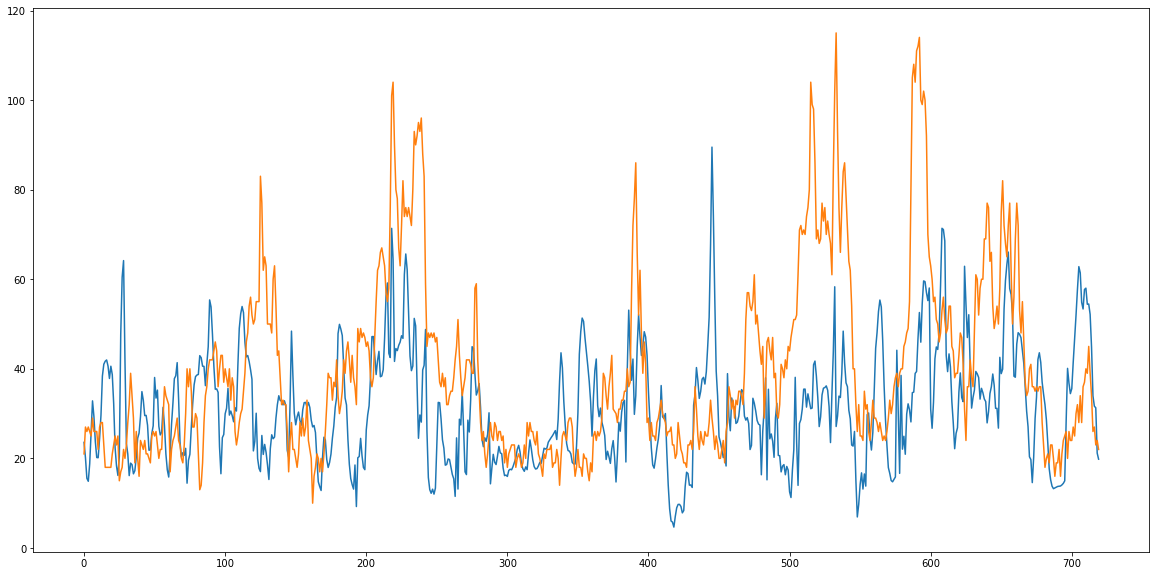

In [1115]:
plt.figure(figsize = (20,10))
plt.plot(np.reshape(np.mean(y_pred * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, axis = 2), [30 * 24]))
plt.plot(np.reshape(val_y, [30 * 24]))

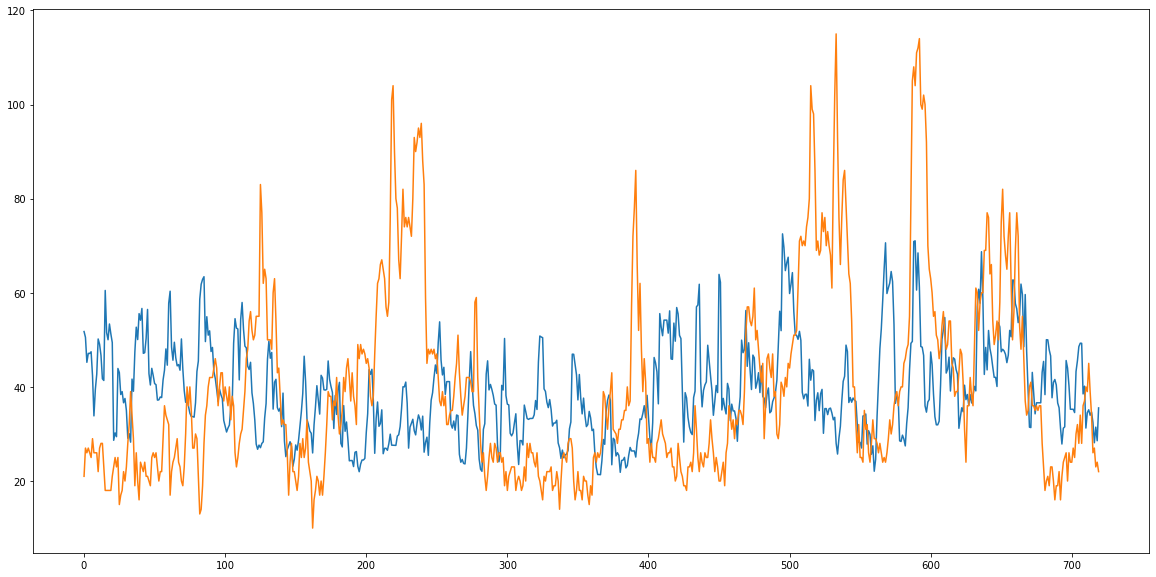

In [1103]:
plt.figure(figsize = (20,10))
plt.plot(y_pred_2)
plt.plot(np.reshape(val_y, [30 * 24]))

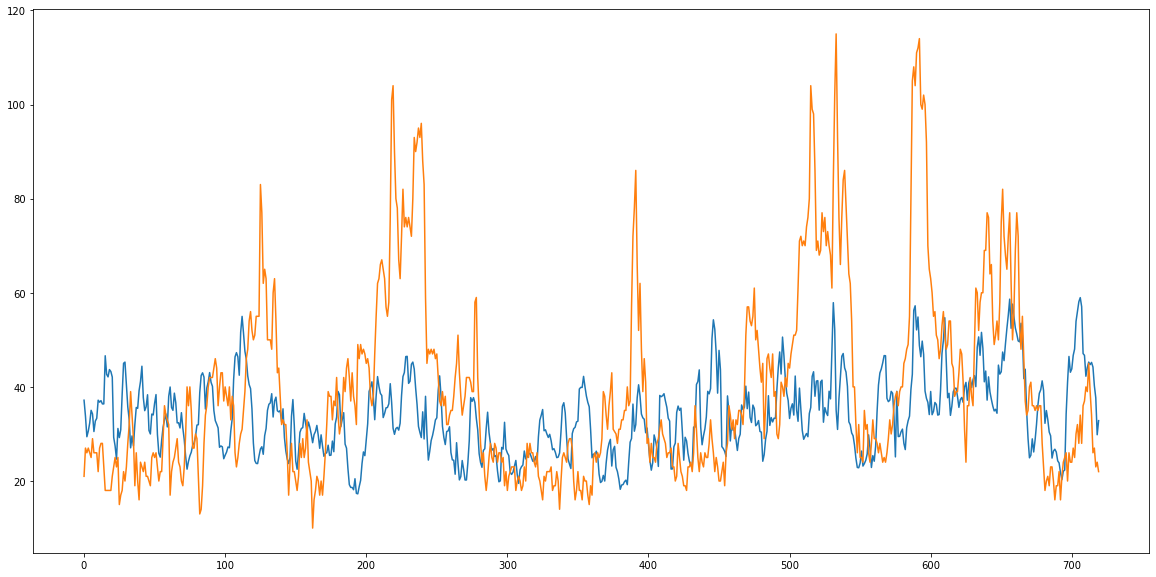

In [1102]:
plt.figure(figsize = (20,10))
plt.plot(ensemble_result)
plt.plot(np.reshape(val_y, [30 * 24]))

In [887]:
np.corrcoef(ensenble_result,
np.reshape(val_y, [30 * 24]))

array([[1.        , 0.48697192],
       [0.48697192, 1.        ]])

In [150]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim / 6),
                                                    activation = "relu")
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(input_shape[-1],
                                      activation = "relu")
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        output = self.dense_input_2(output)
        output = self.dense_embedding(output)        
        output = self.dense_output_1(output)        
        output = self.dense_output_2(output)        
        output = self.output_dense(output)        
        output = self.ae_output(output)        
        return output

In [157]:
AE_LSTM = auto_encoder(60)

In [172]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        output = AE_LSTM(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, AE_LSTM.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE_LSTM.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, 
                                     output * (train_max_dangjin - train_min_dangjin) + train_min_dangjin))

In [173]:
EPOCHS = 1000
batch_size = 50

In [174]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanAbsoluteError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)].copy()
        inp[:,[0,1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23],:] = 0
        inp = tf.Variable(inp, dtype = tf.float32)
        
        tar = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        training_auto_encoder(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            #test_accuracy(X_test_scaled, y_test_scaled)
            #print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.0601 Accuracy 20.5978
Epoch 1 Batch 10 Loss 0.0597 Accuracy 22.2142
Epoch 1 Batch 15 Loss 0.0581 Accuracy 22.2586
Time taken for 1 epoch: 0.32 secs

Epoch 2 Batch 5 Loss 0.0584 Accuracy 22.1824
Epoch 2 Batch 10 Loss 0.0586 Accuracy 22.2349
Epoch 2 Batch 15 Loss 0.0580 Accuracy 22.2132
Time taken for 1 epoch: 0.02 secs

Epoch 3 Batch 5 Loss 0.0582 Accuracy 22.1758
Epoch 3 Batch 10 Loss 0.0583 Accuracy 22.1822
Epoch 3 Batch 15 Loss 0.0579 Accuracy 22.1669
Time taken for 1 epoch: 0.02 secs

Epoch 4 Batch 5 Loss 0.0581 Accuracy 22.1444
Epoch 4 Batch 10 Loss 0.0582 Accuracy 22.1438
Epoch 4 Batch 15 Loss 0.0579 Accuracy 22.1333
Time taken for 1 epoch: 0.02 secs

Epoch 5 Batch 5 Loss 0.0580 Accuracy 22.1185
Epoch 5 Batch 10 Loss 0.0581 Accuracy 22.1166
Epoch 5 Batch 15 Loss 0.0579 Accuracy 22.1082
Time taken for 1 epoch: 0.02 secs

Epoch 6 Batch 5 Loss 0.0579 Accuracy 22.0969
Epoch 6 Batch 10 Loss 0.0580 Accuracy 22.0939
Epoch 6 Batch 15 Loss 0.0578 Accuracy 22.0868
Tim

Epoch 55 Batch 10 Loss 0.0577 Accuracy 21.9296
Epoch 55 Batch 15 Loss 0.0577 Accuracy 21.9294
Time taken for 1 epoch: 0.02 secs

Epoch 56 Batch 5 Loss 0.0577 Accuracy 21.9292
Epoch 56 Batch 10 Loss 0.0577 Accuracy 21.9290
Epoch 56 Batch 15 Loss 0.0577 Accuracy 21.9289
Time taken for 1 epoch: 0.02 secs

Epoch 57 Batch 5 Loss 0.0577 Accuracy 21.9287
Epoch 57 Batch 10 Loss 0.0577 Accuracy 21.9286
Epoch 57 Batch 15 Loss 0.0577 Accuracy 21.9284
Time taken for 1 epoch: 0.02 secs

Epoch 58 Batch 5 Loss 0.0577 Accuracy 21.9282
Epoch 58 Batch 10 Loss 0.0577 Accuracy 21.9281
Epoch 58 Batch 15 Loss 0.0577 Accuracy 21.9279
Time taken for 1 epoch: 0.02 secs

Epoch 59 Batch 5 Loss 0.0577 Accuracy 21.9278
Epoch 59 Batch 10 Loss 0.0577 Accuracy 21.9277
Epoch 59 Batch 15 Loss 0.0577 Accuracy 21.9275
Time taken for 1 epoch: 0.02 secs

Epoch 60 Batch 5 Loss 0.0577 Accuracy 21.9274
Epoch 60 Batch 10 Loss 0.0577 Accuracy 21.9272
Epoch 60 Batch 15 Loss 0.0577 Accuracy 21.9271
Time taken for 1 epoch: 0.02 se

Epoch 109 Batch 15 Loss 0.0577 Accuracy 21.9147
Time taken for 1 epoch: 0.02 secs

Epoch 110 Batch 5 Loss 0.0577 Accuracy 21.9147
Epoch 110 Batch 10 Loss 0.0577 Accuracy 21.9146
Epoch 110 Batch 15 Loss 0.0577 Accuracy 21.9146
Time taken for 1 epoch: 0.02 secs

Epoch 111 Batch 5 Loss 0.0577 Accuracy 21.9145
Epoch 111 Batch 10 Loss 0.0577 Accuracy 21.9144
Epoch 111 Batch 15 Loss 0.0577 Accuracy 21.9144
Time taken for 1 epoch: 0.02 secs

Epoch 112 Batch 5 Loss 0.0577 Accuracy 21.9143
Epoch 112 Batch 10 Loss 0.0577 Accuracy 21.9143
Epoch 112 Batch 15 Loss 0.0577 Accuracy 21.9142
Time taken for 1 epoch: 0.02 secs

Epoch 113 Batch 5 Loss 0.0577 Accuracy 21.9142
Epoch 113 Batch 10 Loss 0.0577 Accuracy 21.9141
Epoch 113 Batch 15 Loss 0.0577 Accuracy 21.9141
Time taken for 1 epoch: 0.02 secs

Epoch 114 Batch 5 Loss 0.0577 Accuracy 21.9140
Epoch 114 Batch 10 Loss 0.0577 Accuracy 21.9139
Epoch 114 Batch 15 Loss 0.0577 Accuracy 21.9139
Time taken for 1 epoch: 0.03 secs

Epoch 115 Batch 5 Loss 0.05

Epoch 156 Batch 15 Loss 0.0577 Accuracy 21.9084
Time taken for 1 epoch: 0.02 secs

Epoch 157 Batch 5 Loss 0.0577 Accuracy 21.9083
Epoch 157 Batch 10 Loss 0.0577 Accuracy 21.9083
Epoch 157 Batch 15 Loss 0.0577 Accuracy 21.9083
Time taken for 1 epoch: 0.02 secs

Epoch 158 Batch 5 Loss 0.0577 Accuracy 21.9082
Epoch 158 Batch 10 Loss 0.0577 Accuracy 21.9082
Epoch 158 Batch 15 Loss 0.0577 Accuracy 21.9082
Time taken for 1 epoch: 0.03 secs

Epoch 159 Batch 5 Loss 0.0577 Accuracy 21.9081
Epoch 159 Batch 10 Loss 0.0577 Accuracy 21.9081
Epoch 159 Batch 15 Loss 0.0577 Accuracy 21.9081
Time taken for 1 epoch: 0.02 secs

Epoch 160 Batch 5 Loss 0.0577 Accuracy 21.9080
Epoch 160 Batch 10 Loss 0.0577 Accuracy 21.9080
Epoch 160 Batch 15 Loss 0.0577 Accuracy 21.9080
Time taken for 1 epoch: 0.02 secs

Epoch 161 Batch 5 Loss 0.0577 Accuracy 21.9079
Epoch 161 Batch 10 Loss 0.0577 Accuracy 21.9079
Epoch 161 Batch 15 Loss 0.0577 Accuracy 21.9079
Time taken for 1 epoch: 0.02 secs

Epoch 162 Batch 5 Loss 0.05


Epoch 204 Batch 5 Loss 0.0577 Accuracy 21.9046
Epoch 204 Batch 10 Loss 0.0577 Accuracy 21.9046
Epoch 204 Batch 15 Loss 0.0577 Accuracy 21.9046
Time taken for 1 epoch: 0.02 secs

Epoch 205 Batch 5 Loss 0.0577 Accuracy 21.9045
Epoch 205 Batch 10 Loss 0.0577 Accuracy 21.9045
Epoch 205 Batch 15 Loss 0.0577 Accuracy 21.9045
Time taken for 1 epoch: 0.02 secs

Epoch 206 Batch 5 Loss 0.0577 Accuracy 21.9045
Epoch 206 Batch 10 Loss 0.0577 Accuracy 21.9045
Epoch 206 Batch 15 Loss 0.0577 Accuracy 21.9044
Time taken for 1 epoch: 0.02 secs

Epoch 207 Batch 5 Loss 0.0577 Accuracy 21.9044
Epoch 207 Batch 10 Loss 0.0577 Accuracy 21.9044
Epoch 207 Batch 15 Loss 0.0577 Accuracy 21.9044
Time taken for 1 epoch: 0.02 secs

Epoch 208 Batch 5 Loss 0.0577 Accuracy 21.9043
Epoch 208 Batch 10 Loss 0.0577 Accuracy 21.9043
Epoch 208 Batch 15 Loss 0.0577 Accuracy 21.9043
Time taken for 1 epoch: 0.02 secs

Epoch 209 Batch 5 Loss 0.0577 Accuracy 21.9043
Epoch 209 Batch 10 Loss 0.0577 Accuracy 21.9043
Epoch 209 Batc

Epoch 256 Batch 5 Loss 0.0577 Accuracy 21.9018
Epoch 256 Batch 10 Loss 0.0577 Accuracy 21.9018
Epoch 256 Batch 15 Loss 0.0577 Accuracy 21.9018
Time taken for 1 epoch: 0.03 secs

Epoch 257 Batch 5 Loss 0.0577 Accuracy 21.9018
Epoch 257 Batch 10 Loss 0.0577 Accuracy 21.9018
Epoch 257 Batch 15 Loss 0.0577 Accuracy 21.9018
Time taken for 1 epoch: 0.02 secs

Epoch 258 Batch 5 Loss 0.0577 Accuracy 21.9018
Epoch 258 Batch 10 Loss 0.0577 Accuracy 21.9017
Epoch 258 Batch 15 Loss 0.0577 Accuracy 21.9017
Time taken for 1 epoch: 0.02 secs

Epoch 259 Batch 5 Loss 0.0577 Accuracy 21.9017
Epoch 259 Batch 10 Loss 0.0577 Accuracy 21.9017
Epoch 259 Batch 15 Loss 0.0577 Accuracy 21.9017
Time taken for 1 epoch: 0.02 secs

Epoch 260 Batch 5 Loss 0.0577 Accuracy 21.9017
Epoch 260 Batch 10 Loss 0.0577 Accuracy 21.9017
Epoch 260 Batch 15 Loss 0.0577 Accuracy 21.9016
Time taken for 1 epoch: 0.02 secs

Epoch 261 Batch 5 Loss 0.0577 Accuracy 21.9016
Epoch 261 Batch 10 Loss 0.0577 Accuracy 21.9016
Epoch 261 Batch

Epoch 303 Batch 15 Loss 0.0577 Accuracy 21.9001
Time taken for 1 epoch: 0.02 secs

Epoch 304 Batch 5 Loss 0.0577 Accuracy 21.9001
Epoch 304 Batch 10 Loss 0.0577 Accuracy 21.9001
Epoch 304 Batch 15 Loss 0.0577 Accuracy 21.9000
Time taken for 1 epoch: 0.02 secs

Epoch 305 Batch 5 Loss 0.0577 Accuracy 21.9000
Epoch 305 Batch 10 Loss 0.0577 Accuracy 21.9000
Epoch 305 Batch 15 Loss 0.0577 Accuracy 21.9000
Time taken for 1 epoch: 0.02 secs

Epoch 306 Batch 5 Loss 0.0577 Accuracy 21.9000
Epoch 306 Batch 10 Loss 0.0577 Accuracy 21.9000
Epoch 306 Batch 15 Loss 0.0577 Accuracy 21.9000
Time taken for 1 epoch: 0.02 secs

Epoch 307 Batch 5 Loss 0.0577 Accuracy 21.9000
Epoch 307 Batch 10 Loss 0.0577 Accuracy 21.9000
Epoch 307 Batch 15 Loss 0.0577 Accuracy 21.9000
Time taken for 1 epoch: 0.02 secs

Epoch 308 Batch 5 Loss 0.0577 Accuracy 21.8999
Epoch 308 Batch 10 Loss 0.0577 Accuracy 21.8999
Epoch 308 Batch 15 Loss 0.0577 Accuracy 21.8999
Time taken for 1 epoch: 0.03 secs

Epoch 309 Batch 5 Loss 0.05

Epoch 351 Batch 5 Loss 0.0577 Accuracy 21.8988
Epoch 351 Batch 10 Loss 0.0577 Accuracy 21.8988
Epoch 351 Batch 15 Loss 0.0577 Accuracy 21.8988
Time taken for 1 epoch: 0.02 secs

Epoch 352 Batch 5 Loss 0.0577 Accuracy 21.8988
Epoch 352 Batch 10 Loss 0.0577 Accuracy 21.8988
Epoch 352 Batch 15 Loss 0.0577 Accuracy 21.8988
Time taken for 1 epoch: 0.02 secs

Epoch 353 Batch 5 Loss 0.0577 Accuracy 21.8988
Epoch 353 Batch 10 Loss 0.0577 Accuracy 21.8987
Epoch 353 Batch 15 Loss 0.0577 Accuracy 21.8987
Time taken for 1 epoch: 0.02 secs

Epoch 354 Batch 5 Loss 0.0577 Accuracy 21.8987
Epoch 354 Batch 10 Loss 0.0577 Accuracy 21.8987
Epoch 354 Batch 15 Loss 0.0577 Accuracy 21.8987
Time taken for 1 epoch: 0.02 secs

Epoch 355 Batch 5 Loss 0.0577 Accuracy 21.8987
Epoch 355 Batch 10 Loss 0.0577 Accuracy 21.8987
Epoch 355 Batch 15 Loss 0.0577 Accuracy 21.8987
Time taken for 1 epoch: 0.02 secs

Epoch 356 Batch 5 Loss 0.0577 Accuracy 21.8987
Epoch 356 Batch 10 Loss 0.0577 Accuracy 21.8987
Epoch 356 Batch

Epoch 398 Batch 5 Loss 0.0577 Accuracy 21.8978
Epoch 398 Batch 10 Loss 0.0577 Accuracy 21.8978
Epoch 398 Batch 15 Loss 0.0577 Accuracy 21.8978
Time taken for 1 epoch: 0.03 secs

Epoch 399 Batch 5 Loss 0.0577 Accuracy 21.8978
Epoch 399 Batch 10 Loss 0.0577 Accuracy 21.8978
Epoch 399 Batch 15 Loss 0.0577 Accuracy 21.8978
Time taken for 1 epoch: 0.02 secs

Epoch 400 Batch 5 Loss 0.0577 Accuracy 21.8978
Epoch 400 Batch 10 Loss 0.0577 Accuracy 21.8978
Epoch 400 Batch 15 Loss 0.0577 Accuracy 21.8978
Time taken for 1 epoch: 0.02 secs

Epoch 401 Batch 5 Loss 0.0577 Accuracy 21.8978
Epoch 401 Batch 10 Loss 0.0577 Accuracy 21.8978
Epoch 401 Batch 15 Loss 0.0577 Accuracy 21.8978
Time taken for 1 epoch: 0.02 secs

Epoch 402 Batch 5 Loss 0.0577 Accuracy 21.8978
Epoch 402 Batch 10 Loss 0.0577 Accuracy 21.8978
Epoch 402 Batch 15 Loss 0.0577 Accuracy 21.8977
Time taken for 1 epoch: 0.02 secs

Epoch 403 Batch 5 Loss 0.0577 Accuracy 21.8977
Epoch 403 Batch 10 Loss 0.0577 Accuracy 21.8977
Epoch 403 Batch

Epoch 445 Batch 10 Loss 0.0577 Accuracy 21.8971
Epoch 445 Batch 15 Loss 0.0577 Accuracy 21.8971
Time taken for 1 epoch: 0.02 secs

Epoch 446 Batch 5 Loss 0.0577 Accuracy 21.8971
Epoch 446 Batch 10 Loss 0.0577 Accuracy 21.8971
Epoch 446 Batch 15 Loss 0.0577 Accuracy 21.8970
Time taken for 1 epoch: 0.02 secs

Epoch 447 Batch 5 Loss 0.0577 Accuracy 21.8970
Epoch 447 Batch 10 Loss 0.0577 Accuracy 21.8970
Epoch 447 Batch 15 Loss 0.0577 Accuracy 21.8970
Time taken for 1 epoch: 0.02 secs

Epoch 448 Batch 5 Loss 0.0577 Accuracy 21.8970
Epoch 448 Batch 10 Loss 0.0577 Accuracy 21.8970
Epoch 448 Batch 15 Loss 0.0577 Accuracy 21.8970
Time taken for 1 epoch: 0.02 secs

Epoch 449 Batch 5 Loss 0.0577 Accuracy 21.8970
Epoch 449 Batch 10 Loss 0.0577 Accuracy 21.8970
Epoch 449 Batch 15 Loss 0.0577 Accuracy 21.8970
Time taken for 1 epoch: 0.02 secs

Epoch 450 Batch 5 Loss 0.0577 Accuracy 21.8970
Epoch 450 Batch 10 Loss 0.0577 Accuracy 21.8970
Epoch 450 Batch 15 Loss 0.0577 Accuracy 21.8970
Time taken for

Epoch 498 Batch 15 Loss 0.0577 Accuracy 21.8964
Time taken for 1 epoch: 0.02 secs

Epoch 499 Batch 5 Loss 0.0577 Accuracy 21.8964
Epoch 499 Batch 10 Loss 0.0577 Accuracy 21.8964
Epoch 499 Batch 15 Loss 0.0577 Accuracy 21.8964
Time taken for 1 epoch: 0.02 secs

Epoch 500 Batch 5 Loss 0.0577 Accuracy 21.8964
Epoch 500 Batch 10 Loss 0.0577 Accuracy 21.8964
Epoch 500 Batch 15 Loss 0.0577 Accuracy 21.8964
Time taken for 1 epoch: 0.02 secs

Epoch 501 Batch 5 Loss 0.0577 Accuracy 21.8963
Epoch 501 Batch 10 Loss 0.0577 Accuracy 21.8963
Epoch 501 Batch 15 Loss 0.0577 Accuracy 21.8963
Time taken for 1 epoch: 0.02 secs

Epoch 502 Batch 5 Loss 0.0577 Accuracy 21.8963
Epoch 502 Batch 10 Loss 0.0577 Accuracy 21.8963
Epoch 502 Batch 15 Loss 0.0577 Accuracy 21.8963
Time taken for 1 epoch: 0.02 secs

Epoch 503 Batch 5 Loss 0.0577 Accuracy 21.8963
Epoch 503 Batch 10 Loss 0.0577 Accuracy 21.8963
Epoch 503 Batch 15 Loss 0.0577 Accuracy 21.8963
Time taken for 1 epoch: 0.02 secs

Epoch 504 Batch 5 Loss 0.05

Epoch 546 Batch 5 Loss 0.0577 Accuracy 21.8959
Epoch 546 Batch 10 Loss 0.0577 Accuracy 21.8959
Epoch 546 Batch 15 Loss 0.0577 Accuracy 21.8959
Time taken for 1 epoch: 0.02 secs

Epoch 547 Batch 5 Loss 0.0577 Accuracy 21.8959
Epoch 547 Batch 10 Loss 0.0577 Accuracy 21.8959
Epoch 547 Batch 15 Loss 0.0577 Accuracy 21.8959
Time taken for 1 epoch: 0.02 secs

Epoch 548 Batch 5 Loss 0.0577 Accuracy 21.8959
Epoch 548 Batch 10 Loss 0.0577 Accuracy 21.8959
Epoch 548 Batch 15 Loss 0.0577 Accuracy 21.8959
Time taken for 1 epoch: 0.02 secs

Epoch 549 Batch 5 Loss 0.0577 Accuracy 21.8958
Epoch 549 Batch 10 Loss 0.0577 Accuracy 21.8958
Epoch 549 Batch 15 Loss 0.0577 Accuracy 21.8958
Time taken for 1 epoch: 0.02 secs

Epoch 550 Batch 5 Loss 0.0577 Accuracy 21.8958
Epoch 550 Batch 10 Loss 0.0577 Accuracy 21.8958
Epoch 550 Batch 15 Loss 0.0577 Accuracy 21.8958
Time taken for 1 epoch: 0.02 secs

Epoch 551 Batch 5 Loss 0.0577 Accuracy 21.8958
Epoch 551 Batch 10 Loss 0.0577 Accuracy 21.8958
Epoch 551 Batch

Epoch 593 Batch 10 Loss 0.0577 Accuracy 21.8955
Epoch 593 Batch 15 Loss 0.0577 Accuracy 21.8955
Time taken for 1 epoch: 0.02 secs

Epoch 594 Batch 5 Loss 0.0577 Accuracy 21.8955
Epoch 594 Batch 10 Loss 0.0577 Accuracy 21.8954
Epoch 594 Batch 15 Loss 0.0577 Accuracy 21.8954
Time taken for 1 epoch: 0.02 secs

Epoch 595 Batch 5 Loss 0.0577 Accuracy 21.8954
Epoch 595 Batch 10 Loss 0.0577 Accuracy 21.8954
Epoch 595 Batch 15 Loss 0.0577 Accuracy 21.8954
Time taken for 1 epoch: 0.02 secs

Epoch 596 Batch 5 Loss 0.0577 Accuracy 21.8954
Epoch 596 Batch 10 Loss 0.0577 Accuracy 21.8954
Epoch 596 Batch 15 Loss 0.0577 Accuracy 21.8954
Time taken for 1 epoch: 0.03 secs

Epoch 597 Batch 5 Loss 0.0577 Accuracy 21.8954
Epoch 597 Batch 10 Loss 0.0577 Accuracy 21.8954
Epoch 597 Batch 15 Loss 0.0577 Accuracy 21.8954
Time taken for 1 epoch: 0.03 secs

Epoch 598 Batch 5 Loss 0.0577 Accuracy 21.8954
Epoch 598 Batch 10 Loss 0.0577 Accuracy 21.8954
Epoch 598 Batch 15 Loss 0.0577 Accuracy 21.8954
Time taken for

Epoch 692 Batch 5 Loss 0.0577 Accuracy 21.8948
Epoch 692 Batch 10 Loss 0.0577 Accuracy 21.8948
Epoch 692 Batch 15 Loss 0.0577 Accuracy 21.8948
Time taken for 1 epoch: 0.02 secs

Epoch 693 Batch 5 Loss 0.0577 Accuracy 21.8948
Epoch 693 Batch 10 Loss 0.0577 Accuracy 21.8948
Epoch 693 Batch 15 Loss 0.0577 Accuracy 21.8948
Time taken for 1 epoch: 0.02 secs

Epoch 694 Batch 5 Loss 0.0577 Accuracy 21.8948
Epoch 694 Batch 10 Loss 0.0577 Accuracy 21.8948
Epoch 694 Batch 15 Loss 0.0577 Accuracy 21.8948
Time taken for 1 epoch: 0.02 secs

Epoch 695 Batch 5 Loss 0.0577 Accuracy 21.8947
Epoch 695 Batch 10 Loss 0.0577 Accuracy 21.8947
Epoch 695 Batch 15 Loss 0.0577 Accuracy 21.8947
Time taken for 1 epoch: 0.02 secs

Epoch 696 Batch 5 Loss 0.0577 Accuracy 21.8947
Epoch 696 Batch 10 Loss 0.0577 Accuracy 21.8947
Epoch 696 Batch 15 Loss 0.0577 Accuracy 21.8947
Time taken for 1 epoch: 0.02 secs

Epoch 697 Batch 5 Loss 0.0577 Accuracy 21.8947
Epoch 697 Batch 10 Loss 0.0577 Accuracy 21.8947
Epoch 697 Batch

Epoch 738 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 738 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for 1 epoch: 0.03 secs

Epoch 739 Batch 5 Loss 0.0577 Accuracy 21.8945
Epoch 739 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 739 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for 1 epoch: 0.03 secs

Epoch 740 Batch 5 Loss 0.0577 Accuracy 21.8945
Epoch 740 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 740 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for 1 epoch: 0.02 secs

Epoch 741 Batch 5 Loss 0.0577 Accuracy 21.8945
Epoch 741 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 741 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for 1 epoch: 0.02 secs

Epoch 742 Batch 5 Loss 0.0577 Accuracy 21.8945
Epoch 742 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 742 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for 1 epoch: 0.03 secs

Epoch 743 Batch 5 Loss 0.0577 Accuracy 21.8945
Epoch 743 Batch 10 Loss 0.0577 Accuracy 21.8945
Epoch 743 Batch 15 Loss 0.0577 Accuracy 21.8945
Time taken for

Epoch 785 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 785 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 785 Batch 15 Loss 0.0577 Accuracy 21.8943
Time taken for 1 epoch: 0.03 secs

Epoch 786 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 786 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 786 Batch 15 Loss 0.0577 Accuracy 21.8943
Time taken for 1 epoch: 0.03 secs

Epoch 787 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 787 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 787 Batch 15 Loss 0.0577 Accuracy 21.8943
Time taken for 1 epoch: 0.02 secs

Epoch 788 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 788 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 788 Batch 15 Loss 0.0577 Accuracy 21.8943
Time taken for 1 epoch: 0.02 secs

Epoch 789 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 789 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 789 Batch 15 Loss 0.0577 Accuracy 21.8943
Time taken for 1 epoch: 0.02 secs

Epoch 790 Batch 5 Loss 0.0577 Accuracy 21.8943
Epoch 790 Batch 10 Loss 0.0577 Accuracy 21.8943
Epoch 790 Batch


Epoch 832 Batch 5 Loss 0.0577 Accuracy 21.8934
Epoch 832 Batch 10 Loss 0.0577 Accuracy 21.8934
Epoch 832 Batch 15 Loss 0.0577 Accuracy 21.8934
Time taken for 1 epoch: 0.02 secs

Epoch 833 Batch 5 Loss 0.0577 Accuracy 21.8934
Epoch 833 Batch 10 Loss 0.0577 Accuracy 21.8934
Epoch 833 Batch 15 Loss 0.0577 Accuracy 21.8934
Time taken for 1 epoch: 0.02 secs

Epoch 834 Batch 5 Loss 0.0577 Accuracy 21.8934
Epoch 834 Batch 10 Loss 0.0577 Accuracy 21.8934
Epoch 834 Batch 15 Loss 0.0577 Accuracy 21.8934
Time taken for 1 epoch: 0.02 secs

Epoch 835 Batch 5 Loss 0.0577 Accuracy 21.8934
Epoch 835 Batch 10 Loss 0.0577 Accuracy 21.8934
Epoch 835 Batch 15 Loss 0.0577 Accuracy 21.8934
Time taken for 1 epoch: 0.02 secs

Epoch 836 Batch 5 Loss 0.0577 Accuracy 21.8934
Epoch 836 Batch 10 Loss 0.0577 Accuracy 21.8934
Epoch 836 Batch 15 Loss 0.0577 Accuracy 21.8933
Time taken for 1 epoch: 0.02 secs

Epoch 837 Batch 5 Loss 0.0577 Accuracy 21.8933
Epoch 837 Batch 10 Loss 0.0577 Accuracy 21.8933
Epoch 837 Batc

Epoch 879 Batch 5 Loss 0.0577 Accuracy 21.8925
Epoch 879 Batch 10 Loss 0.0577 Accuracy 21.8925
Epoch 879 Batch 15 Loss 0.0577 Accuracy 21.8924
Time taken for 1 epoch: 0.02 secs

Epoch 880 Batch 5 Loss 0.0577 Accuracy 21.8924
Epoch 880 Batch 10 Loss 0.0577 Accuracy 21.8924
Epoch 880 Batch 15 Loss 0.0577 Accuracy 21.8924
Time taken for 1 epoch: 0.02 secs

Epoch 881 Batch 5 Loss 0.0577 Accuracy 21.8924
Epoch 881 Batch 10 Loss 0.0577 Accuracy 21.8924
Epoch 881 Batch 15 Loss 0.0577 Accuracy 21.8924
Time taken for 1 epoch: 0.02 secs

Epoch 882 Batch 5 Loss 0.0577 Accuracy 21.8924
Epoch 882 Batch 10 Loss 0.0577 Accuracy 21.8924
Epoch 882 Batch 15 Loss 0.0577 Accuracy 21.8924
Time taken for 1 epoch: 0.02 secs

Epoch 883 Batch 5 Loss 0.0577 Accuracy 21.8924
Epoch 883 Batch 10 Loss 0.0577 Accuracy 21.8924
Epoch 883 Batch 15 Loss 0.0577 Accuracy 21.8924
Time taken for 1 epoch: 0.02 secs

Epoch 884 Batch 5 Loss 0.0577 Accuracy 21.8924
Epoch 884 Batch 10 Loss 0.0577 Accuracy 21.8924
Epoch 884 Batch

Epoch 925 Batch 10 Loss 0.0577 Accuracy 21.8916
Epoch 925 Batch 15 Loss 0.0577 Accuracy 21.8916
Time taken for 1 epoch: 0.02 secs

Epoch 926 Batch 5 Loss 0.0577 Accuracy 21.8916
Epoch 926 Batch 10 Loss 0.0577 Accuracy 21.8916
Epoch 926 Batch 15 Loss 0.0577 Accuracy 21.8916
Time taken for 1 epoch: 0.02 secs

Epoch 927 Batch 5 Loss 0.0577 Accuracy 21.8916
Epoch 927 Batch 10 Loss 0.0577 Accuracy 21.8916
Epoch 927 Batch 15 Loss 0.0577 Accuracy 21.8915
Time taken for 1 epoch: 0.02 secs

Epoch 928 Batch 5 Loss 0.0577 Accuracy 21.8915
Epoch 928 Batch 10 Loss 0.0577 Accuracy 21.8915
Epoch 928 Batch 15 Loss 0.0577 Accuracy 21.8915
Time taken for 1 epoch: 0.02 secs

Epoch 929 Batch 5 Loss 0.0577 Accuracy 21.8915
Epoch 929 Batch 10 Loss 0.0577 Accuracy 21.8915
Epoch 929 Batch 15 Loss 0.0577 Accuracy 21.8915
Time taken for 1 epoch: 0.02 secs

Epoch 930 Batch 5 Loss 0.0577 Accuracy 21.8915
Epoch 930 Batch 10 Loss 0.0577 Accuracy 21.8915
Epoch 930 Batch 15 Loss 0.0577 Accuracy 21.8915
Time taken for

Epoch 972 Batch 15 Loss 0.0577 Accuracy 21.8908
Time taken for 1 epoch: 0.02 secs

Epoch 973 Batch 5 Loss 0.0577 Accuracy 21.8908
Epoch 973 Batch 10 Loss 0.0577 Accuracy 21.8908
Epoch 973 Batch 15 Loss 0.0577 Accuracy 21.8908
Time taken for 1 epoch: 0.02 secs

Epoch 974 Batch 5 Loss 0.0577 Accuracy 21.8908
Epoch 974 Batch 10 Loss 0.0577 Accuracy 21.8908
Epoch 974 Batch 15 Loss 0.0577 Accuracy 21.8907
Time taken for 1 epoch: 0.02 secs

Epoch 975 Batch 5 Loss 0.0577 Accuracy 21.8907
Epoch 975 Batch 10 Loss 0.0577 Accuracy 21.8907
Epoch 975 Batch 15 Loss 0.0577 Accuracy 21.8907
Time taken for 1 epoch: 0.02 secs

Epoch 976 Batch 5 Loss 0.0577 Accuracy 21.8907
Epoch 976 Batch 10 Loss 0.0577 Accuracy 21.8907
Epoch 976 Batch 15 Loss 0.0577 Accuracy 21.8907
Time taken for 1 epoch: 0.02 secs

Epoch 977 Batch 5 Loss 0.0577 Accuracy 21.8907
Epoch 977 Batch 10 Loss 0.0577 Accuracy 21.8907
Epoch 977 Batch 15 Loss 0.0577 Accuracy 21.8907
Time taken for 1 epoch: 0.02 secs

Epoch 978 Batch 5 Loss 0.05

In [206]:
X_test_dangjin_scaled[1]

array([[0.08410229, 0.05299235, 0.65726338, 0.29607171, 0.07724756],
       [0.08383865, 0.05193778, 0.05088321, 0.29870815, 0.07461113],
       [0.08410229, 0.0551015 , 0.57817031, 0.30134458, 0.07724756],
       [0.08331136, 0.05246507, 0.94727129, 0.30925389, 0.06670182],
       [0.08726602, 0.05852887, 0.5254416 , 0.30925389, 0.07461113],
       [0.08436594, 0.05958344, 0.57817031, 0.30925389, 0.06406538],
       [0.08647509, 0.06432903, 0.57817031, 0.30925389, 0.07724756],
       [0.08410229, 0.06195624, 0.57817031, 0.30925389, 0.06670182],
       [0.08542051, 0.0593198 , 0.57817031, 0.30925389, 0.07724756],
       [0.08568416, 0.05852887, 0.57817031, 0.30925389, 0.06933825],
       [0.08621144, 0.05826523, 0.57817031, 0.30925389, 0.07724756],
       [0.0859478 , 0.05589243, 0.65726338, 0.30925389, 0.07461113],
       [0.08489322, 0.05852887, 0.7627208 , 0.30925389, 0.07724756],
       [0.08331136, 0.05641972, 0.65726338, 0.30925389, 0.06406538],
       [0.08225679, 0.05826523, 0.

In [212]:
inp_test = X_test_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)].copy()
inp_test[:,[0,1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23],:] = 0
inp_test = tf.Variable(inp, dtype = tf.float32)

tar_test = tf.Variable(X_test_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

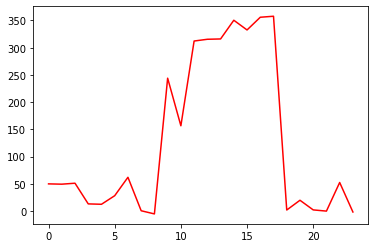

In [215]:
plt.plot(AE(inp_test)[1,:,2] * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, color = "red")
plt.plot(tar_test[1,:,2] * (train_max_dangjin - train_min_dangjin) + train_min_dangjin, color = "green")